# Utilities

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

def make_corr_plot(actual, predicted):

    m = 1
    b = 0
    correlation_coefficient, p_value = pearsonr(actual[:10000], predicted[:10000])
    x = np.arange(actual.min(), actual.max(), step=0.1)

    fig = plt.figure(figsize=(8, 6))
    plt.scatter(actual, predicted, s=30, alpha=0.2)
    plt.plot(x, m*x + b, color='red')
    plt.xlabel('Truth Number of Primary Ionizations')
    plt.ylabel('Predicted Number of Primary Ionizations')
    plt.text(0.05,0.95, f"Correlation coefficient = {correlation_coefficient:.2f}", fontsize=12, color='black', 
             transform=plt.gca().transAxes,
             horizontalalignment='left',    
             verticalalignment='top', )
    plt.grid(True, color='gray', linestyle='--', alpha=0.4)
    plt.title('Truth vs. Predicted Number of Primary Ionizations')

def plot_percent_error(actual, predicted):
    mask = actual != 0
    actual = actual[mask]
    predicted = predicted[mask]
    error = ((predicted - actual)/actual) * 100

    plt.hist(error,bins=np.arange(-100, 100, 2),histtype='bar',label='Error', edgecolor="black", fc="#69b3a2", alpha=0.3)
    plt.title('Histogram of Percent Error')
    plt.xlabel('Error (%)')

    mean = np.mean(error)
    std = np.std(error.astype(np.float32))

    plt.axvline(mean, color='red', linestyle='--', linewidth=2)
    
    plt.text(0.05, 0.95, f'Mean: {mean:.2f}\nSTD: {std:.2f}',
    transform=plt.gca().transAxes,
    horizontalalignment='left',    
    verticalalignment='top',  
    color='black', fontsize=11)
    plt.grid(True, color='gray', linestyle='--', alpha=0.4)


def flatten_list(item, flattened):

    if isinstance(item, list) or isinstance(item, np.ndarray):
        for sub_item in item:
            flatten_list(sub_item, flattened)
    
    else:
        flattened.append(item)

def box_plot_weights(model):
    layers = model.layers
    layer_weights = []
    layer_names = []

    for layer in layers:
        if (len(layer.get_weights()) != 0):
            layer_names.append(layer.name)
            curr_weights = []
            flatten_list(layer.get_weights(), curr_weights)
            layer_weights.append(curr_weights)
            
    print(layer_names)
    print(layer_weights)

    print(len(layer_names))
    print(len(layer_weights))

    fig, ax = plt.subplots()
    bp = ax.boxplot(layer_weights, vert = False, patch_artist=True, labels = layer_names)

    from matplotlib import cm
    from matplotlib.colors import Normalize

    cmap = cm.Blues
    # Normalize values for the colormap (e.g., from 0 to 1 for a smooth gradient)
    norm = Normalize(vmin=0, vmax=1) 

    for i, box in enumerate(bp['boxes']):
            color = cmap(norm(i / (len(data) - 1))) # Normalize index to 0-1 range
            box.set_facecolor(color)

    yticks = []

    for i in range(len(layer_names)):
        yticks.append(i + 1)
    plt.yticks(yticks, layer_names)
    plt.xlabel('Weight Values')
    plt.title('Weight Distribution')

    plt.show()


# Load data

In [32]:
compress = False
compress_factor = 1

if compress == False:
    compress_factor = 1

In [33]:
truncate = True
num_timepoints = 500

if truncate == False:
    num_timepoints = 3000

In [34]:
from tqdm import tqdm
import numpy as np

label = 'focal'
grulabel = ''
mixlabel = ''

gru_c1layers=[[16,5,5,'valid',False],[16,5,1,'same',False],[16,5,1,'same',False]]
gru_rlayers=[]
gru_c2layers=[[16,5,5,'valid']]
#gru_c2layers=[[32,1,1,'valid'],[32,1,1,'valid']]
gru_dlayers=[32,32]

doGRUTrain = True

patchSize = 100
c1layers=[32]
m1layers=[32,patchSize]
m2layers=[32,32]
d1layers=[16,1]
d2layers=[16]

doMLPMixTrain = True

loss_fn = "categorical_focal_crossentropy"
learningRate = 1e-3
nEpochs = 25
batchSize = 64

model_dir = 'models/'

In [35]:
def load_data(dir, files):
    # Dictionary to store lists of arrays for each key
    combined_data = {}

    # Loop through files and collect arrays
    for filename in files:
        origdata = np.load(dir+filename)
        for key in origdata.files:
            if key not in combined_data:
                combined_data[key] = []
            combined_data[key].append(origdata[key])

    # Concatenate arrays along the first axis for each key
    return {key: np.concatenate(arr_list, axis=0) for key, arr_list in combined_data.items()}


In [36]:
data = load_data("./data/processed_data_train/",
                 ["batch_0.npz",
                  #"batch_1.npz",
                  #"batch_2.npz",
                  #"batch_3.npz",
                  #"batch_4.npz", 
                 ])
data = {d:data[d][:100000] for d in data} # reduce size in memory

if truncate:
    data['wf_i'] = data['wf_i'][:,:num_timepoints]
    mask = data['tag_times'] >= num_timepoints
    data['tag_times'][mask] = 0
    data['tag_values'][mask] = 0

In [37]:
testdata = load_data("./data/processed_data_test/",
                     ["batch_0.npz",
                      #"batch_1.npz",
                      #"batch_2.npz",
                      #"batch_3.npz",
                      #"batch_4.npz",
                    ])

if compress:
    compressed = []
    for i in range(testdata['wf_i'].shape[0]):
        wf_i = testdata['wf_i'][i]
        wf_i = wf_i.reshape(-1, compress_factor)
        wf_i = wf_i.mean(axis=1)

        compressed.append(wf_i)

    testdata['wf_i'] = np.asarray(compressed)

if truncate:
    testdata['wf_i'] = testdata['wf_i'][:,:num_timepoints]
    mask = testdata['tag_times'] >= num_timepoints
    testdata['tag_times'][mask] = 0
    testdata['tag_values'][mask] = 0
        

In [38]:
wf = np.zeros(3000)
testdata['tag_times']
wf[testdata['tag_times'][0]] = testdata['tag_values'][0]

In [39]:
wfs = []
for i in range(len(testdata['tag_times'])):
    wf = np.zeros(3000)
    testdata['tag_times']
    wf[testdata['tag_times'][i]] = testdata['tag_values'][i]
    wfs.append(wf)

In [40]:
first_half = []
second_half = []

for i in range(len(wfs)):
    first_half.append(np.sum((wfs[i][0:1500] == 1).astype(np.int32)))
    second_half.append(np.sum((wfs[i][1501:] == 1).astype(np.int32)))

In [41]:
def make_corr_plot_test(actual, predicted):

    m, b = np.polyfit(actual[:10000], predicted[:10000], 1)
    correlation_coefficient, p_value = pearsonr(actual[:10000], predicted[:10000])
    x = np.arange(actual.min(), actual.max(), step=0.1)

    fig = plt.figure(figsize=(8, 6))
    plt.scatter(actual, predicted, s=30, alpha=0.2)
    plt.plot(x, m*x + b, color='red', label='Line of Best Fit')
    plt.xlabel('# Primaries in First Half of Waveform')
    plt.ylabel('# Primaries in Second Half of Waveform')
    plt.text(0.05,0.95, f"Correlation coefficient = {correlation_coefficient:.2f}", fontsize=12, color='black', 
             transform=plt.gca().transAxes,
             horizontalalignment='left',    
             verticalalignment='top', )
    plt.grid(True, color='gray', linestyle='--', alpha=0.4)
    plt.title('Correlation Between # Primaries in First and Second Half of Waveform')

In [42]:
# first_half = np.asarray(first_half)
# second_half = np.asarray(second_half)
# make_corr_plot_test(first_half, second_half)

In [43]:
print(data['wf_i'].shape)
print(data['mom'].shape)
print(data['tag_times'].shape)
print(data['tag_values'].shape)

(100000, 500)
(100000,)
(100000, 300)
(100000, 300)


In [44]:
#print(data['wf_i'][0])
#print(data['mom'][0])
#print(data['tag_times'][0])
print(testdata['tag_values'][0])

[1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]


In [45]:
def expand_values(values, times, tlength=3000, ohe=True, combine=False):
    # values: (300,)
    # times: (300,)
    data = np.zeros((num_timepoints,), dtype=np.float32)

    # Place values at the correct times
    valid_mask = (times >= 0) & (times < tlength)
    times = times[valid_mask]
    values = values[valid_mask]

    if truncate:
        mask = times >= num_timepoints
        times[mask] = 0
        values[mask] = 0

    data[times] = values
    
    if ohe:
        ohe_data = np.zeros((num_timepoints, 3), dtype=np.float32)
        for i in range(3):
            ohe_data[:, i] = (data == i).astype(np.float32)
        if combine:
            ohe_data[:, 1] = np.any(ohe_data[:, 1:], axis=-1)
            ohe_data[:, 2] = 0.0
        return ohe_data
    else:
        if combine:
            data = (data > 0).astype(np.float32)
        return data[:, None]  # shape (3000, 1)
    
def np_expand_values(values,times,tlength = 3000, ohe = True, combine = False):
    data = np.zeros((values.shape[0],tlength))
    data[np.arange(times.shape[0])[:,None],times] = values
    if ohe:
        data = np.concatenate([(data==i)[:,:,None] for i in range(3)],axis=-1).astype(np.float32)
        if combine:
            data[:,:,1] = np.any(data[:,:,1:],axis=-1)
            data[:,:,2] = 0.
    else:
        if combine:
            data = (data>0).astype(np.float32)
    return data

def batched_expand_values(values, times, batch_size=1000, tlength=3000, ohe=True, combine=False):
    outputs = []
    for i in tqdm(range(0, len(values), batch_size)):
        v_batch = values[i:i+batch_size]
        t_batch = times[i:i+batch_size]
        out = np_expand_values(v_batch, t_batch, tlength=tlength, ohe=ohe, combine=combine)
        outputs.append(out)
    return np.concatenate(outputs, axis=0)

In [46]:
test = expand_values(data['tag_values'],data['tag_times'],data['wf_i'].shape[1])
print(test.shape)

(500, 3)


In [47]:
import matplotlib.pyplot as plt

In [48]:
# iev = 0
# plt.figure(figsize=(8, 6))
# plt.scatter(np.arange(testdata['wf_i'][iev].shape[0]),testdata['wf_i'][iev],s=4, color='gray') #, label='Background')
# plt.scatter(testdata['tag_times'][iev,testdata['tag_values'][iev]==1],testdata['wf_i'][iev][testdata['tag_times'][iev,testdata['tag_values'][iev]==1]],s=5,color='r', label='Primary ionization')
# plt.scatter(testdata['tag_times'][iev,testdata['tag_values'][iev]==2],testdata['wf_i'][iev][testdata['tag_times'][iev,testdata['tag_values'][iev]==2]],s=5,color='blue', label='Secondary ionization')
# plt.xlabel("Time Step")
# plt.ylabel("Amplitude")
# plt.title("Waveform Visualization")
# plt.grid(True, linestyle='--', color='gray', alpha = 0.4)
# # plt.legend()
# plt.ylim(0)

In [49]:
import tensorflow as tf
from tensorflow import keras
# Import tf/keras modules
from keras.layers import Dense
from keras.layers import Input
# This clears the Keras session
tf.keras.backend.clear_session()

In [50]:
import os, sys

def load_npz_individual(file_path_bytes):
    path = file_path_bytes.decode("utf-8")
    data = np.load(path)

    # print(data)
    wf_i = data["wf_i"][:, :num_timepoints].astype(np.float32)      # (N, 3000)
    # print('wf shape ', wf_i.shape)
    tag_values = data["tag_values"]               # (N, ?)
    tag_times = data["tag_times"]                 # (N, ?)

    if truncate:
        mask = tag_times >= num_timepoints
        tag_times[mask] = 0
        tag_values[mask] = 0

    return wf_i, tag_values, tag_times

def build_dataset(file_list, batch_size, tlength=3000, ohe=True, combine=False, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices(file_list)

    def file_to_dataset(file_path):
        wf_i, tag_values, tag_times = tf.numpy_function(
            func=load_npz_individual,
            inp=[file_path],
            Tout=[tf.float32, tf.int32, tf.int32]
        )
        # Shapes are unknown, need to set
        wf_i.set_shape([None, num_timepoints])         # (N, 3000)

        if compress:
            wf_i = tf.reshape(wf_i, [tf.shape(wf_i)[0], -1, compress_factor])
            wf_i = tf.reduce_mean(wf_i, axis=-1)
            wf_i.set_shape([None, int(num_timepoints/compress_factor)]) 
  
        tag_values.set_shape([None, 300])     # (N, ?)
        tag_times.set_shape([None, 300])       # (N, ?)

        ex_ds = tf.data.Dataset.from_tensor_slices((wf_i, tag_values, tag_times))

        def process(wf_i_ex, tag_values_ex, tag_times_ex):
            # print(wf_i_ex)
            wf_i_ex = tf.expand_dims(wf_i_ex, axis=-1)  # (3000, 1)
            # print(tag_values_ex)
            boolean_tensor = tf.equal(tag_values_ex, 1)
            # print('boolean tensor ', boolean_tensor)
            y = tf.reduce_sum(tf.cast(boolean_tensor, tf.int32))

            print(y)
            if compress:
                wf_i_ex.set_shape([int(num_timepoints/compress_factor), 1])

            else:
                wf_i_ex.set_shape([num_timepoints, 1])
                
            return wf_i_ex, y
        

        return ex_ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)

    #if shuffle:
    #    ds = ds.shuffle(len(file_list))

    ds = ds.flat_map(file_to_dataset)
    ds = ds.shuffle(512)  # shuffle individual examples
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [51]:
from sklearn.model_selection import train_test_split
import glob

# Load file paths
file_list = sorted(glob.glob("./data/processed_data_train/*.npz"))
train_files, val_files = train_test_split(file_list, test_size=0.2, shuffle=False)

train_ds = build_dataset(train_files, batchSize)
val_ds = build_dataset(val_files, batchSize, shuffle=False)

Tensor("Sum:0", shape=(), dtype=int32)
Tensor("Sum:0", shape=(), dtype=int32)


In [52]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 500, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [53]:
# Convert the dataset to a single NumPy array for features and labels
all_features = []
all_labels = []
count = 0
# Using a for-loop for more explicit control
for feature_batch, label_batch in train_ds.as_numpy_iterator():
    if count > 1562:
        break
    all_features.append(feature_batch)
    all_labels.append(label_batch)
    count += 1

features_np = np.concatenate(all_features, axis=0)
labels_np = np.concatenate(all_labels, axis=0)


(array([2.4900e+02, 3.8290e+03, 1.6971e+04, 3.0672e+04, 2.7997e+04,
        1.4532e+04, 4.6640e+03, 9.5800e+02, 1.4400e+02, 1.6000e+01]),
 array([ 1. ,  3.9,  6.8,  9.7, 12.6, 15.5, 18.4, 21.3, 24.2, 27.1, 30. ]),
 <BarContainer object of 10 artists>)

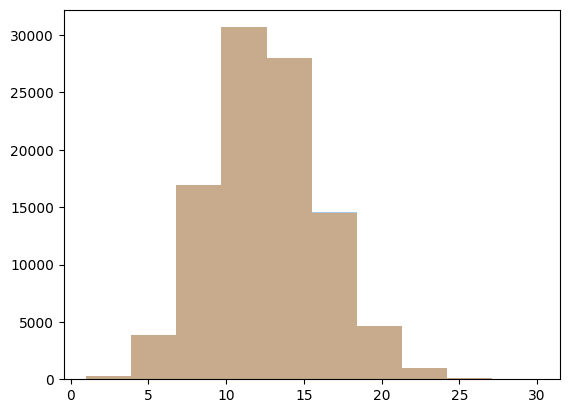

In [54]:
import matplotlib.pyplot as plt
plt.hist(np.sum((data['tag_values'] == 1).astype(np.int32), axis = 1), alpha = 0.4)
plt.hist(labels_np, alpha = 0.4)

In [55]:
np.sum((data['tag_values'] == 1).astype(np.int32), axis = 1)

array([15, 19,  9, ...,  9, 11, 18])

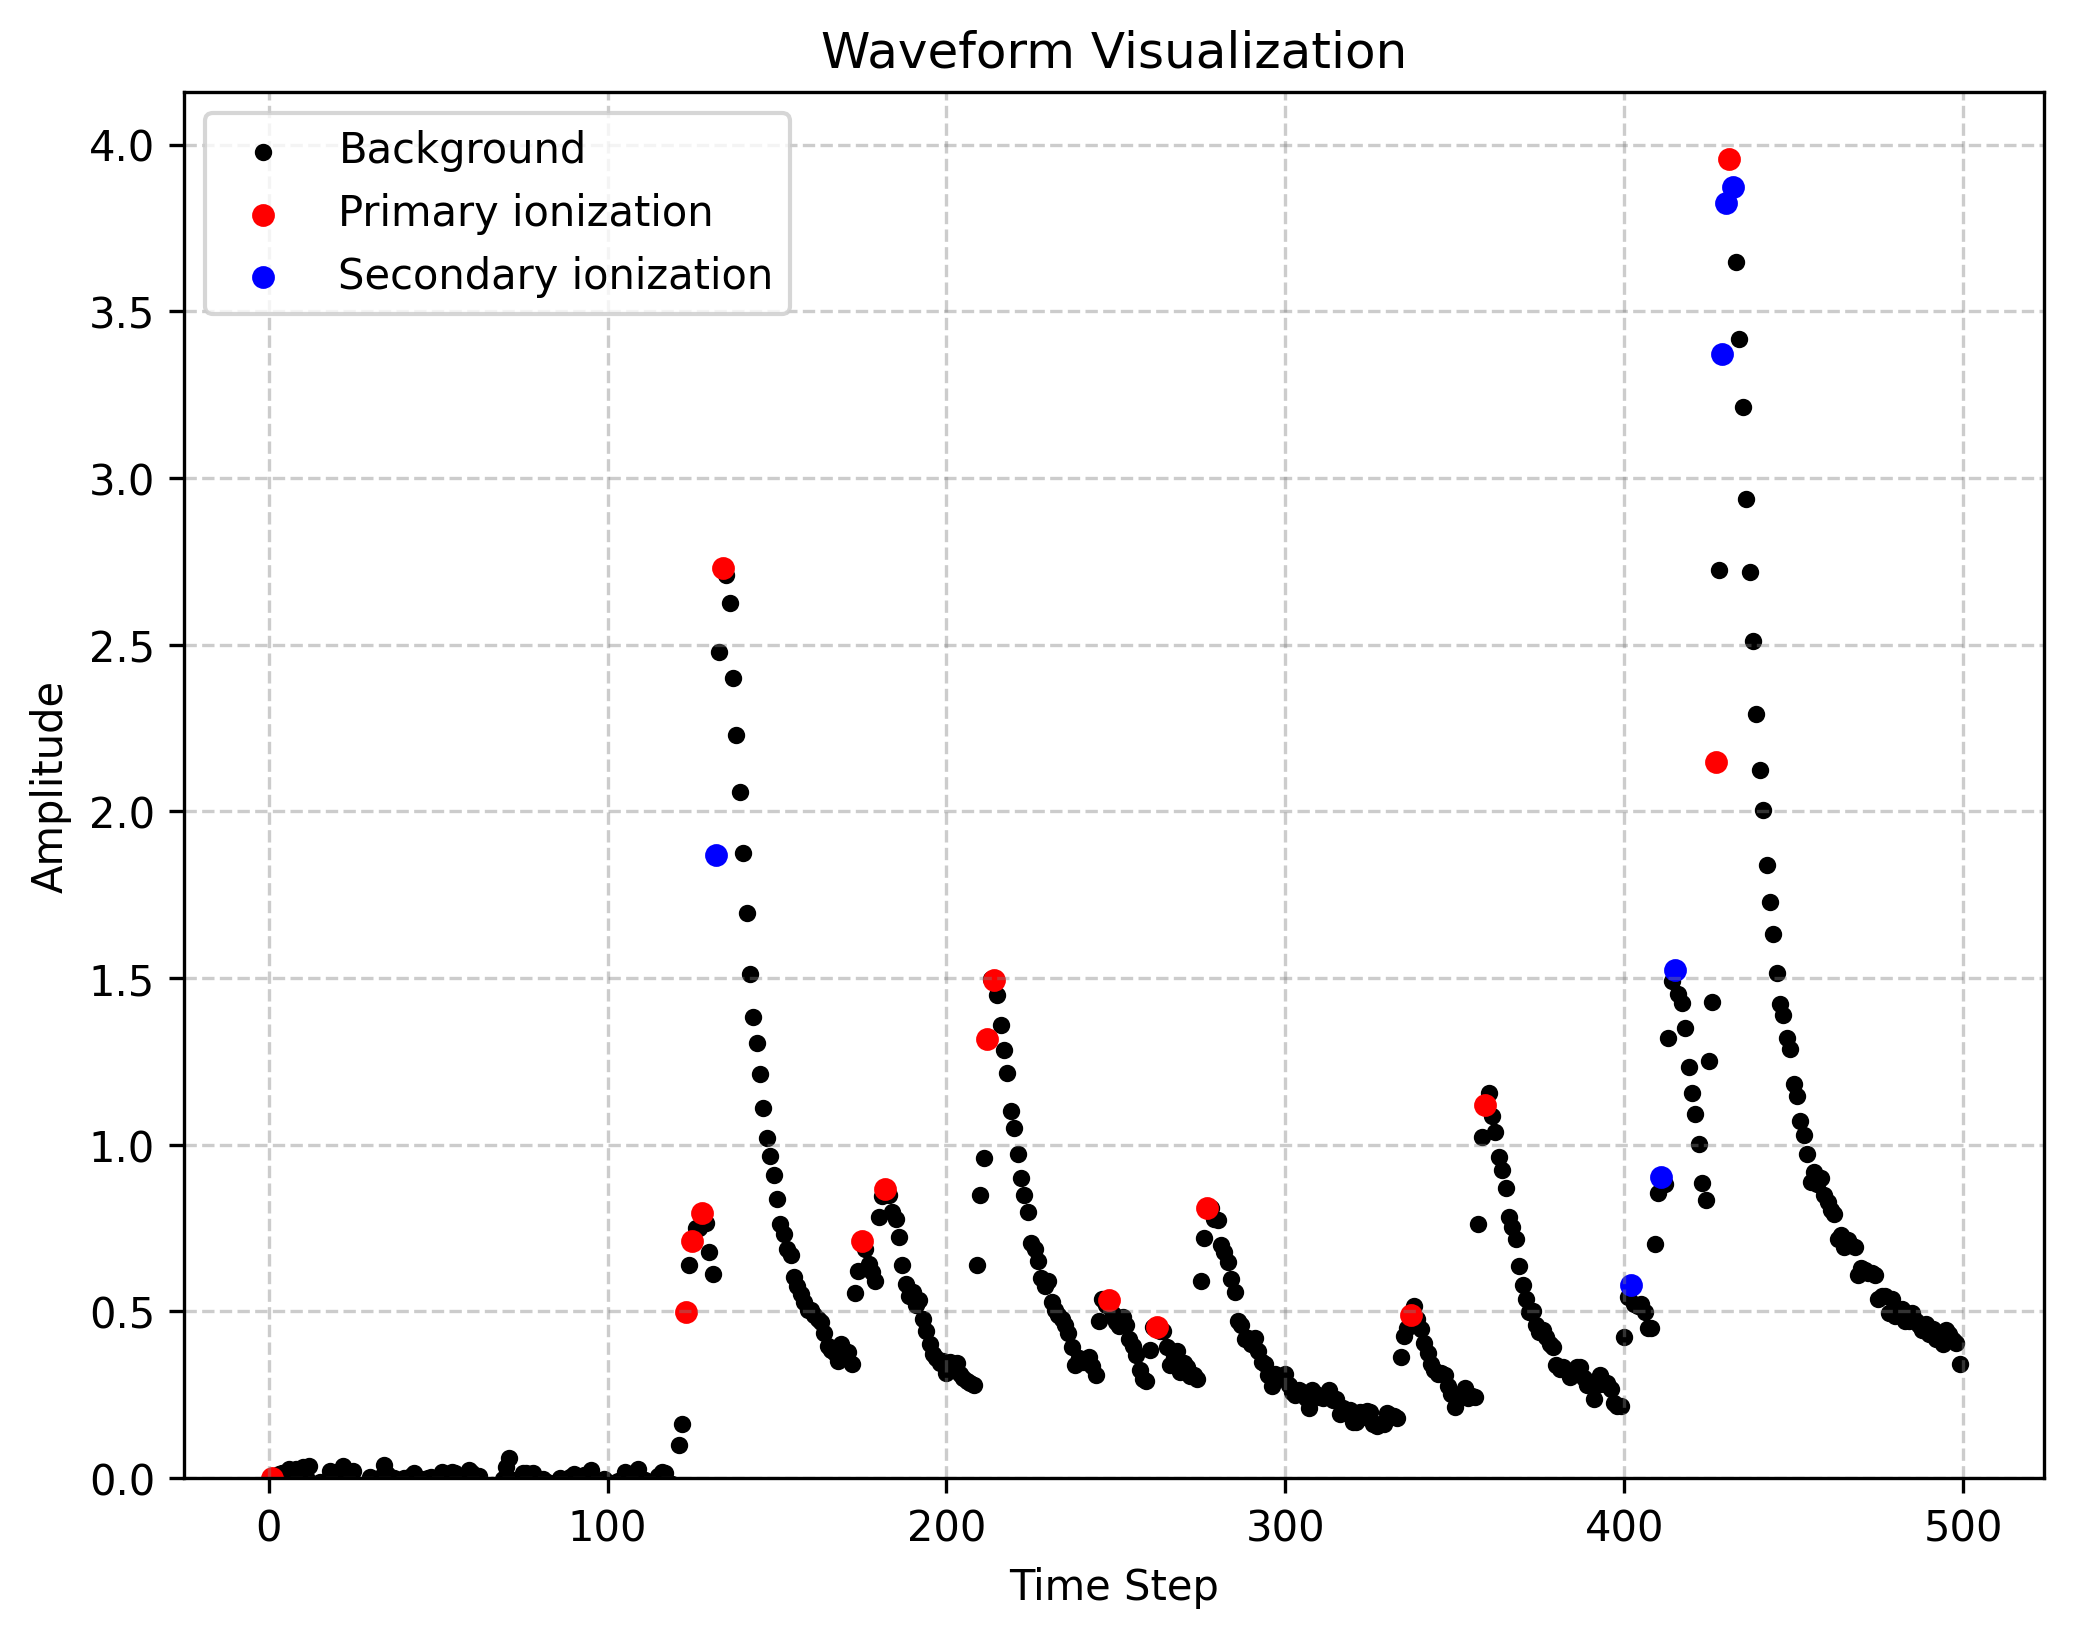

In [56]:
import matplotlib.pyplot as plt
iev = 4
plt.figure(figsize=(8, 6), dpi=300)
plt.scatter(np.arange(data['wf_i'][iev].shape[0]),data['wf_i'][iev],s=10, color='black', label='Background')
plt.scatter(data['tag_times'][iev,data['tag_values'][iev]==1],data['wf_i'][iev][data['tag_times'][iev,data['tag_values'][iev]==1]],s=20,color='r', label='Primary ionization')
plt.scatter(data['tag_times'][iev,data['tag_values'][iev]==2],data['wf_i'][iev][data['tag_times'][iev,data['tag_values'][iev]==2]],s=20,color='blue', label='Secondary ionization')
plt.xlabel("Time Step")
plt.ylabel("Amplitude")
plt.title("Waveform Visualization")
plt.grid(True, linestyle='--', color='gray', alpha = 0.4)
plt.legend()
plt.ylim(0)
plt.savefig('waveform.png')

In [57]:
testdata['wf_i']

array([[ 5.15131420e-03, -1.23360883e-02, -1.00005008e-02, ...,
         3.20856646e-02,  2.68470664e-02,  6.78239837e-02],
       [-1.87673811e-02, -5.34232752e-03,  4.01390530e-03, ...,
         2.46704459e+00,  2.57790422e+00,  2.59886050e+00],
       [ 3.56888697e-02,  6.74556009e-03, -3.31748948e-02, ...,
         1.34730026e-01,  9.20494348e-02,  1.12572186e-01],
       ...,
       [-1.99296209e-03, -1.71949752e-02,  1.52785918e-02, ...,
         1.80084258e-01,  1.56623065e-01,  1.09495543e-01],
       [ 8.53851251e-03, -1.30856307e-02,  1.24480920e-02, ...,
         2.57632852e-01,  2.40784779e-01,  2.38884762e-01],
       [ 1.92878302e-03, -1.78722367e-02, -9.47251637e-03, ...,
         7.74585009e-02,  9.79442224e-02,  1.10712975e-01]], dtype=float32)

# Create and train model

### Downsampled CNN

In [222]:
from keras.layers import Conv1D, MaxPooling1D, Dense, Input, Flatten, GlobalAveragePooling1D, GlobalMaxPool1D, GRU, Reshape, Conv1DTranspose, UpSampling1D, Normalization, Dropout
 
def create_model(c1layers=[[32,1,1,'valid',False]], dlayers=[32,32]):
    inputs = Input(shape=(int(num_timepoints/compress_factor),1))
    x = inputs
    # x = Normalization()(x)
    npool = 0
    for i,c in enumerate(c1layers):
        x = Conv1D(c[0],c[1],c[2],padding=c[3],activation="relu")(x)
        if c[4]:
            x = MaxPooling1D(5)(x)
            npool = npool+1
            

    x = GlobalAveragePooling1D()(x)
    
    for i,d in enumerate(dlayers):
        x = Dense(d,activation="relu")(x)

    # x = Dropout(0.25)(x)

    # x = Conv1D(1, 4, 1, activation = 'linear')(x)

    # outputs = Reshape((1,))(x)
        
    outputs = Dense(1,activation='linear')(x)
    
    return keras.Model(inputs=inputs, outputs=outputs, name="cnn-regressor")
 
 
c1layers=[[16,5,5,'same',False], [16,5,1,'same',False], [16,5,1,'same',False]]
dlayers=[32, 32]
model = create_model(c1layers, dlayers)
 
print(model.summary())

Model: "cnn-regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 500, 1)]          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 100, 16)           96        
                                                                 
 conv1d_4 (Conv1D)           (None, 100, 16)           1296      
                                                                 
 conv1d_5 (Conv1D)           (None, 100, 16)           1296      
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_15 (Dense)            (None, 32)                544       
                                                     

In [ ]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.optimizers import Adam

loss_fn = tf.keras.losses.MeanSquaredError()
batchSize = 32
nEpochs = 25
learningRate = 1e-3

earlystop = EarlyStopping(
        monitor="val_loss", 
        patience=10,
        restore_best_weights=True,
        min_delta=0.0, 
    )

reducelr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_delta=0.,
    min_lr=1.e-7,
)

# dndxgru = dndx_gru(gru_c1layers,gru_rlayers,gru_c2layers,gru_dlayers)

print(model.summary())
# Define Optimizer and compile
opt = Adam(learning_rate=learningRate)
model.compile(loss=loss_fn, optimizer=opt,
    metrics=tf.keras.metrics.MeanAbsoluteError(name='mae'))

if doGRUTrain:
    history = model.fit(train_ds, validation_data=val_ds,
                      batch_size=batchSize, epochs=nEpochs, callbacks=(earlystop,reducelr))

    # model.save('models/norm_cf_4_no_GAP_3conv.keras')
else:
    model = keras.models.load_model('models/dndxgru_%s.keras'%(label+grulabel))

Model: "cnn-regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 500, 1)]          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 100, 16)           96        
                                                                 
 conv1d_4 (Conv1D)           (None, 100, 16)           1296      
                                                                 
 conv1d_5 (Conv1D)           (None, 100, 16)           1296      
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_15 (Dense)            (None, 32)                544       
                                                     

### Downsampled, only dense

In [29]:
import keras
from keras.layers import Dense, Input, AveragePooling1D, Reshape, GlobalAveragePooling1D, MaxPooling1D, Flatten

def create_model():
    inputs = Input(shape=(int(num_timepoints/compress_factor),))
    x = inputs
    # x = Dense(64, activation="relu")(x)
    x = Dense(8, activation="relu")(x)
    x = Dense(32, activation="relu")(x)
    # x = Dense(1, activation="relu")(x)
    x = Dense(8, activation="relu")(x)
    # # x = MaxPooling1D(100)(x)
    # # x = Flatten()(x)
    # # x = Reshape((1,))(x)
    x = Dense(1,activation='linear')(x)
    outputs = x

    return keras.Model(inputs=inputs, outputs=outputs, name="DNN")

model = create_model()
model.summary()

Model: "DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500)]             0         
                                                                 
 dense_4 (Dense)             (None, 8)                 4008      
                                                                 
 dense_5 (Dense)             (None, 32)                288       
                                                                 
 dense_6 (Dense)             (None, 8)                 264       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 4569 (17.85 KB)
Trainable params: 4569 (17.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
import keras
from keras.layers import Dense, Input, AveragePooling1D, Reshape, GlobalAveragePooling1D, MaxPooling1D, Flatten
num_timepoints = 500
compress_factor = 1
def create_model():
    inputs = Input(shape=(int(num_timepoints/compress_factor),))
    x = inputs
    # x = Dense(64, activation="relu")(x)
    x = Dense(8, activation="relu")(x)
    # x = Dense(32, activation="relu")(x)
    # x = Dense(1, activation="relu")(x)
    x = Dense(8, activation="relu")(x)
    # # x = MaxPooling1D(100)(x)
    # # x = Flatten()(x)
    # # x = Reshape((1,))(x)
    x = Dense(1,activation='linear')(x)
    outputs = x

    return keras.Model(inputs=inputs, outputs=outputs, name="DNN")

model = create_model()
model.summary()

model.save('models/dnn_8_8.keras')

Model: "DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500)]             0         
                                                                 
 dense_3 (Dense)             (None, 8)                 4008      
                                                                 
 dense_4 (Dense)             (None, 8)                 72        
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 4089 (15.97 KB)
Trainable params: 4089 (15.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.optimizers import Adam

loss_fn = tf.keras.losses.MeanSquaredError()
batchSize = 64
nEpochs = 75
learningRate = 4e-4

earlystop = EarlyStopping(
        monitor="val_loss", 
        patience=10,
        restore_best_weights=True,
        min_delta=0.0, 
    )

reducelr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=5,
    min_delta=0.,
    min_lr=1.e-7,
)

# dndxgru = dndx_gru(gru_c1layers,gru_rlayers,gru_c2layers,gru_dlayers)

print(model.summary())
# Define Optimizer and compile
opt = Adam(learning_rate=learningRate)
model.compile(loss=loss_fn, optimizer=opt,
    metrics=tf.keras.metrics.MeanAbsoluteError(name='mae'))

if doGRUTrain:
    history = model.fit(train_ds, validation_data=val_ds,
                      batch_size=batchSize, epochs=nEpochs, callbacks=(earlystop,reducelr))

    # model.save('models/cf_2_tiny_dense.keras')
else:
    model = keras.models.load_model('models/dndxgru_%s.keras'%(label+grulabel))

Model: "DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500)]             0         
                                                                 
 dense_3 (Dense)             (None, 8)                 4008      
                                                                 
 dense_4 (Dense)             (None, 8)                 72        
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 4089 (15.97 KB)
Trainable params: 4089 (15.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/75
6250/6250 [==============================] - 24s 3ms/step - loss: 54.4479 - mae: 5.2859 - val_loss: 14.1321 - val_mae: 2.5657 - lr: 4.0000e-04
Ep

KeyboardInterrupt: 

In [31]:
model.save('models/dense_8_8_lr=4e-4.keras')

In [31]:
model.save('models/500_dense_8_32_8_lr=6e-4.keras')

In [72]:
def create_and_train_model(learningRate):
    model = create_model()
    print(model.summary())

    loss_fn = tf.keras.losses.MeanSquaredError()
    batchSize = 64
    nEpochs = 10

    earlystop = EarlyStopping(
            monitor="val_loss", 
            patience=10,
            restore_best_weights=True,
            min_delta=0.0, 
        )

    reducelr = ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=3,
        min_delta=0.,
        min_lr=1.e-7,
    )

    # Define Optimizer and compile
    opt = Adam(learning_rate=learningRate)
    model.compile(loss=loss_fn, optimizer=opt,
        metrics=tf.keras.metrics.MeanAbsoluteError(name='mae'))

    history = model.fit(train_ds, validation_data=val_ds,
                      batch_size=batchSize, epochs=nEpochs, callbacks=(earlystop,reducelr))

    return model

In [73]:
learningRates = [1e-4, 2e-4, 3e-4, 5e-4, 6e-4, 7e-4, 8e-4, 9e-4, 10e-4]
mse = []

for lr in learningRates:
    print(f"Training model with learning rate: {lr}")
    model = create_and_train_model(lr)
    model.save(f'models/500_dense_8_32_8_lr_{lr}.keras')
    print(f"Model saved for learning rate: {lr}")
    mse.append(model.evaluate(val_ds, verbose=0)[0])


Training model with learning rate: 0.0001
Model: "DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 500)]             0         
                                                                 
 dense_20 (Dense)            (None, 8)                 4008      
                                                                 
 dense_21 (Dense)            (None, 32)                288       
                                                                 
 dense_22 (Dense)            (None, 8)                 264       
                                                                 
 dense_23 (Dense)            (None, 1)                 9         
                                                                 
Total params: 4569 (17.85 KB)
Trainable params: 4569 (17.85 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________________________________________

None
Epoch 1/10
6250/6250 [==============================] - 25s 3ms/step - loss: 116.6720 - mae: 9.7260 - val_loss: 77.4239 - val_mae: 7.6174 - lr: 1.0000e-04
Epoch 2/10
6250/6250 [==============================] - 25s 3ms/step - loss: 35.4853 - mae: 4.6279 - val_loss: 12.0208 - val_mae: 2.3304 - lr: 1.0000e-04
Epoch 3/10
6250/6250 [==============================] - 25s 3ms/step - loss: 8.7829 - mae: 2.1556 - val_loss: 7.7260 - val_mae: 2.0602 - lr: 1.0000e-04
Epoch 4/10
6250/6250 [==============================] - 25s 3ms/step - loss: 7.5984 - mae: 2.0583 - val_loss: 7.0039 - val_mae: 2.0218 - lr: 1.0000e-04
Epoch 5/10
6250/6250 [==============================] - 25s 3ms/step - loss: 7.1040 - mae: 2.0266 - val_loss: 6.7205 - val_mae: 1.9979 - lr: 1.0000e-04
Epoch 6/10
6250/6250 [==============================] - 25s 3ms/step - loss: 6.8455 - mae: 2.0030 - val_loss: 6.5280 - val_mae: 1.9773 - lr: 1.0000e-04
Epoch 7/10
6250/6250 [==============================] - 25s 3ms/step - loss: 6

In [74]:
mse 

[6.006002426147461,
 5.931219577789307,
 5.733735084533691,
 5.602978706359863,
 5.6904706954956055,
 5.3071112632751465,
 5.5545148849487305,
 5.480565547943115,
 5.785809516906738]

In [75]:
mse = [6.006002426147461,
 5.931219577789307,
 5.733735084533691,
 5.602978706359863,
 5.6904706954956055,
 5.3071112632751465,
 5.5545148849487305,
 5.480565547943115,
 5.785809516906738]

# learningRates = [1e-2, 3.16e-3, 1e-3, 3.16e-4, 1e-4, 3.16e-5]

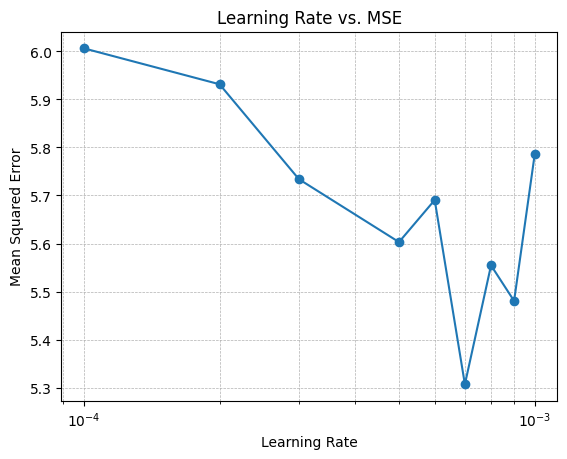

In [76]:
import matplotlib.pyplot as plt
# learningRates = [1e-2, 3.16e-3, 1e-3, 3.16e-4, 1e-4, 3.16e-5, 1e-5, 3.16e-6, 1e-6]
plt.plot(learningRates, mse, marker='o')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Squared Error')
plt.title('Learning Rate vs. MSE')
plt.grid(True, which='both', linestyle='--', linewidth=0.5) 

### Hyperparameter tuning

In [27]:
import keras_tuner as kt

In [28]:
import keras
from keras.layers import Conv1D, MaxPooling1D, Dense, Input, Flatten, GlobalAveragePooling1D, GRU, Reshape, Conv1DTranspose, UpSampling1D
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.optimizers import Adam

def create_model(hp): 
    inputs = Input(shape=(int(num_timepoints/compress_factor),))
    x = inputs  

    x = Dense(8, activation='relu')(x)

    for i in range(1,4):
        x = Dense(units=hp.Int(f'dense_units_{i+1}', min_value=5, max_value=35, step=5), activation="relu")(x)
    
    x = Dense(1, activation='linear')(x)

    outputs = x

    model = keras.Model(inputs=inputs, outputs=outputs, name="gru")

    hp_learning_rate = hp.Float('learning_rate', min_value=1e-6, max_value=1e-2, sampling='log', default=1e-3)

    loss_fn = tf.keras.losses.MeanSquaredError()
    opt = Adam(learning_rate=hp_learning_rate)
    model.compile(loss=loss_fn, optimizer=opt,
        metrics=tf.keras.metrics.MeanSquaredError(name='mse')) 
    
    return model



In [ ]:
nEpochs = 10

earlystop = EarlyStopping(
        monitor="val_loss", 
        patience=10,
        restore_best_weights=True,
        min_delta=0.0, 
    )

reducelr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=2,
    min_delta=0.,
    min_lr=1.e-7,
)

tuner = kt.Hyperband(
    hypermodel=create_model,
    objective=kt.Objective('val_mse',direction="min"), # Optimize for validation recall (important for imbalanced data)
    max_epochs=50,          # Max epochs to train any model during the search
    factor=3,               # Reduction factor for the number of models and epochs
    directory='my_tuning_dir_500_dense_v2', # Directory to store results
    project_name='focal_loss_tuning' # Name of the tuning project
)

batchSize = 64 # Fixed batch size for all trials in this example

tuner.search(train_ds,
             epochs=nEpochs, # Use your nEpochs from your script
             batch_size=batchSize, # Pass batch size here
             validation_data=val_ds,
             callbacks=[earlystop, reducelr])

Trial 75 Complete [00h 06m 35s]
val_mse: 5.329287052154541

Best val_mse So Far: 5.167749881744385
Total elapsed time: 2d 07h 14m 10s

Search: Running Trial #76

Value             |Best Value So Far |Hyperparameter
30                |15                |dense_units_2
20                |35                |dense_units_3
15                |15                |dense_units_4
2.333e-06         |0.00061595        |learning_rate
17                |50                |tuner/epochs
0                 |17                |tuner/initial_epoch
1                 |3                 |tuner/bracket
0                 |3                 |tuner/round

Epoch 1/17
6250/6250 [==============================] - 24s 3ms/step - loss: 161.5976 - mse: 161.5976 - val_loss: 150.5580 - val_mse: 150.5580 - lr: 2.3330e-06
Epoch 2/17
6250/6250 [==============================] - 24s 3ms/step - loss: 147.2692 - mse: 147.2692 - val_loss: 144.1132 - val_mse: 144.1132 - lr: 2.3330e-06
Epoch 3/17
6250/6250 [=======================

2025-08-10 20:54:14.022588: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1 of 512
2025-08-10 20:54:14.025310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


6250/6250 [==============================] - 41s 5ms/step - loss: 137.5671 - mse: 137.5671 - val_loss: 135.0781 - val_mse: 135.0781 - lr: 2.3330e-06
Epoch 5/17
6250/6250 [==============================] - 26s 3ms/step - loss: 132.8642 - mse: 132.8642 - val_loss: 130.2687 - val_mse: 130.2687 - lr: 2.3330e-06
Epoch 6/17
6250/6250 [==============================] - 24s 3ms/step - loss: 128.2373 - mse: 128.2373 - val_loss: 125.4545 - val_mse: 125.4545 - lr: 2.3330e-06
Epoch 7/17
6250/6250 [==============================] - 23s 3ms/step - loss: 123.5408 - mse: 123.5408 - val_loss: 120.5348 - val_mse: 120.5348 - lr: 2.3330e-06
Epoch 8/17
6250/6250 [==============================] - 24s 3ms/step - loss: 118.7773 - mse: 118.7773 - val_loss: 115.4642 - val_mse: 115.4642 - lr: 2.3330e-06
Epoch 9/17
6250/6250 [==============================] - 23s 3ms/step - loss: 113.9383 - mse: 113.9383 - val_loss: 110.3532 - val_mse: 110.3532 - lr: 2.3330e-06
Epoch 10/17
6250/6250 [============================

In [31]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"\nBest Hyperparameters found:")
print(f"  Learning Rate: {best_hps.get('learning_rate'):.6f}")
print(f"  Num Dense layers: {best_hps.get('num_dense_layers')}")
print(f"  Dense Conv Units Layer 1: {best_hps.get('dense_units_1')}")
print(f"  Dense Conv Units Layer 2: {best_hps.get('dense_units_2')}")
print(f"  Dense Conv Units Layer 3: {best_hps.get('dense_units_3')}")


best_model = tuner.get_best_models(num_models=1)[0]

print("\n--- Best Model Summary ---")
best_model.summary()


Best Hyperparameters found:
  Learning Rate: 0.000631
  Num Dense layers: 3
  Dense Conv Units Layer 1: 25
  Dense Conv Units Layer 2: 25
  Dense Conv Units Layer 3: 15

--- Best Model Summary ---
Model: "gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 dense (Dense)               (None, 25)                12525     
                                                                 
 dense_1 (Dense)             (None, 25)                650       
                                                                 
 dense_2 (Dense)             (None, 15)                390       
                                                                 
 dense_3 (Dense)             (None, 1)                 16        
                                                               

In [32]:
model.save('models/500_tiniest_possible')

INFO:tensorflow:Assets written to: models/500_tiniest_possible/assets


INFO:tensorflow:Assets written to: models/500_tiniest_possible/assets


In [203]:
model.save('models/500_dense.keras')

### Create/train/load

In [ ]:
from keras.layers import Conv1D, MaxPooling1D, Dense, Input, Flatten, GlobalAveragePooling1D, GlobalMaxPool1D, GRU, Reshape, Conv1DTranspose, UpSampling1D
 
def create_model(c1layers=[[32,1,1,'valid',False]], dlayers=[32,32]):
    inputs = Input(shape=(3000,1))
    x = inputs
    npool = 0
    for i,c in enumerate(c1layers):
        x = Conv1D(c[0],c[1],c[2],padding=c[3],activation="relu")(x)
        if c[4]:
            x = MaxPooling1D(5)(x)
            npool = npool+1
    
    # x = MaxPooling1D(60)(x)
    x = Flatten()(x)
    
    for i,d in enumerate(dlayers):
        x = Dense(d,activation="relu")(x)
        
    outputs = Dense(1,activation='linear')(x)
    
    return keras.Model(inputs=inputs, outputs=outputs, name="cnn-regressor")
 
 
c1layers=[[8,500,5,'same',True], [8,5,1,'same',True]]
dlayers=[16, 32]
model = create_model(c1layers, dlayers)
 
print(model.summary())

Model: "cnn-regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 3000, 1)]         0         
                                                                 
 conv1d_6 (Conv1D)           (None, 600, 8)            4008      
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 120, 8)            0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 120, 8)            328       
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 24, 8)             0         
 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 192)             

In [ ]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.optimizers import Adam

loss_fn = tf.keras.losses.MeanSquaredError()
batchSize = 64
nEpochs = 25
learningRate = 1e-2

earlystop = EarlyStopping(
        monitor="val_loss", 
        patience=10,
        restore_best_weights=True,
        min_delta=0.0, 
    )

reducelr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_delta=0.,
    min_lr=1.e-7,
)

# dndxgru = dndx_gru(gru_c1layers,gru_rlayers,gru_c2layers,gru_dlayers)

print(model.summary())
# Define Optimizer and compile
opt = Adam(learning_rate=learningRate)
model.compile(loss=loss_fn, optimizer=opt,
    metrics=tf.keras.metrics.MeanAbsoluteError(name='mae'))

if doGRUTrain:
    history = model.fit(train_ds, validation_data=val_ds,
                      batch_size=batchSize, epochs=nEpochs, callbacks=(earlystop,reducelr))

    model.save('models/v2_regression_dndxgru_focal.keras')
else:
    model = keras.models.load_model('models/dndxgru_%s.keras'%(label+grulabel))

Model: "cnn-regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 3000, 1)]         0         
                                                                 
 conv1d_6 (Conv1D)           (None, 600, 8)            4008      
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 120, 8)            0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 120, 8)            328       
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 24, 8)             0         
 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 192)             

KeyboardInterrupt: 

In [ ]:
model.save('models/v2_conv_max_pooling.keras')

In [ ]:
model = keras.models.load_model('models/regression_dndxgru_focal.keras')

### Plots

In [27]:
import keras
model = keras.models.load_model('models/FINAL_SPECS/500_dense_8_32_8_lr=6e-4.keras')

In [27]:
# if yes quantization

from qkeras.utils import _add_supported_quantized_objects

co = {}
_add_supported_quantized_objects(co)
model = keras.models.load_model('models/FINAL_SPECS/8_2_0.8_pruned_500_dense_8_32_8_lr=6e-4.h5', custom_objects=co)

In [ ]:
8_2_0.8_pruned_500_dense_8_32_8_lr=6e-4.h5

#### Downsampling plot

In [4]:
import keras
from pathlib import Path

ntest = 100000
dir = 'models/lrreduced_tiny_denses'
model_paths = [str(p.resolve()) for p in Path(dir).rglob('*') if p.is_file()]

perc_error_mean = []
perc_error_std = []
compress_factors = []

for model_path in model_paths:
    print('Current path: ', (model_path.split('/')[-1]))
    compress_factor = int(model_path.split('/')[-1].split('_')[1])
    compress_factors.append(compress_factor)
    print(compress_factor)
    compress = True

    model = keras.models.load_model(model_path)

    testdata = load_data("./processed_data_test/",
                     ["batch_0.npz",
                      #"batch_1.npz",
                      #"batch_2.npz",
                      #"batch_3.npz",
                      #"batch_4.npz",
                    ])

    if compress:
        compressed = []
        for i in range(testdata['wf_i'].shape[0]):
            wf_i = testdata['wf_i'][i]
            wf_i = wf_i.reshape(-1, compress_factor)
            wf_i = wf_i.mean(axis=1)

            compressed.append(wf_i)

        testdata['wf_i'] = np.asarray(compressed)

    predicted = np.asarray(model.predict(testdata['wf_i']))[:ntest].reshape(ntest)
    actual = np.asarray(np.sum(testdata['tag_values'] == 1, axis = 1))[:ntest].reshape(ntest)

    error = ((predicted - actual)/actual) * 100

    mean = np.mean(error)
    std = np.std(error.astype(np.float32))

    perc_error_mean.append(mean)
    perc_error_std.append(std)
    


2025-07-30 23:56:59.032444: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-30 23:56:59.054110: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Current path:  cf_5_lrreduced_dense.keras
5
3125/3125 [==============================] - 1s 281us/step
Current path:  cf_10_lrreduced_dense.keras
10
3125/3125 [==============================] - 1s 280us/step
Current path:  cf_30_lrreduced_dense.keras
30
3125/3125 [==============================] - 1s 271us/step
Current path:  cf_8_lrreduced_dense.keras
8
3125/3125 [==============================] - 1s 306us/step
Current path:  cf_4_lrreduced_dense.keras
4
3125/3125 [==============================] - 1s 273us/step
Current path:  cf_3_lrreduced_dense.keras
3
3125/3125 [==============================] - 1s 275us/step
Current path:  cf_6_lrreduced_dense.keras
6
3125/3125 [==============================] - 1s 276us/step


In [5]:
compress_factors = np.asarray(compress_factors)
perc_error_mean = np.asarray(perc_error_mean)
perc_error_std = np.asarray(perc_error_std)

Text(0.5, 1.0, 'Compress Factor vs. STD Percent Error')

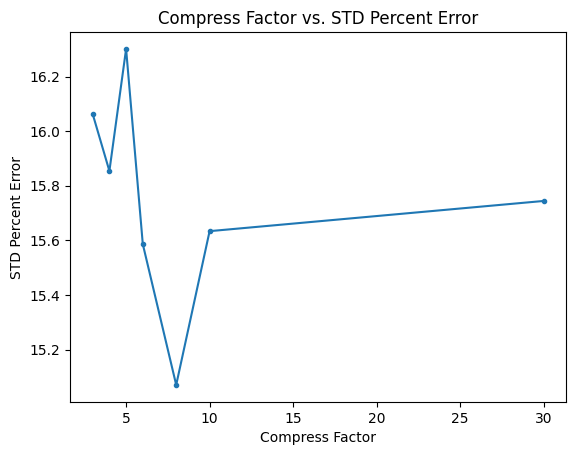

In [6]:
plt.plot(np.sort(compress_factors), np.asarray(perc_error_std)[np.argsort(compress_factors)],ls='-', marker='.')
plt.xlabel('Compress Factor')
plt.ylabel('STD Percent Error')
plt.title('Compress Factor vs. STD Percent Error')

Text(0.5, 1.0, 'Compress Factor vs. Mean Percent Error')

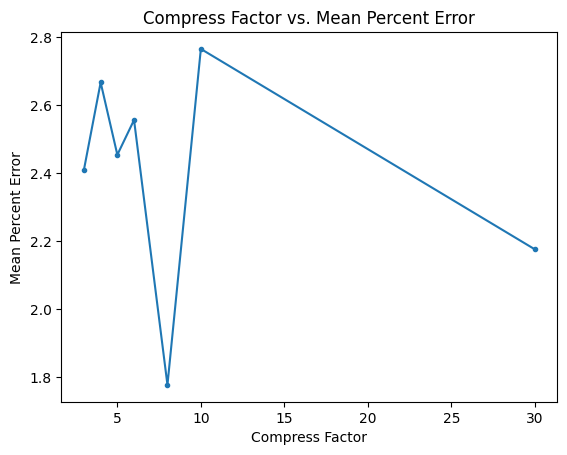

In [7]:
plt.plot(np.sort(compress_factors), np.asarray(perc_error_mean)[np.argsort(compress_factors)],ls='-', marker='.')
plt.xlabel('Compress Factor')
plt.ylabel('Mean Percent Error')
plt.title('Compress Factor vs. Mean Percent Error')

#### Standard performance plots

In [28]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val loss')
plt.legend()

NameError: name 'history' is not defined

3125/3125 [==============================] - 1s 364us/step


<Figure size 2400x1800 with 0 Axes>

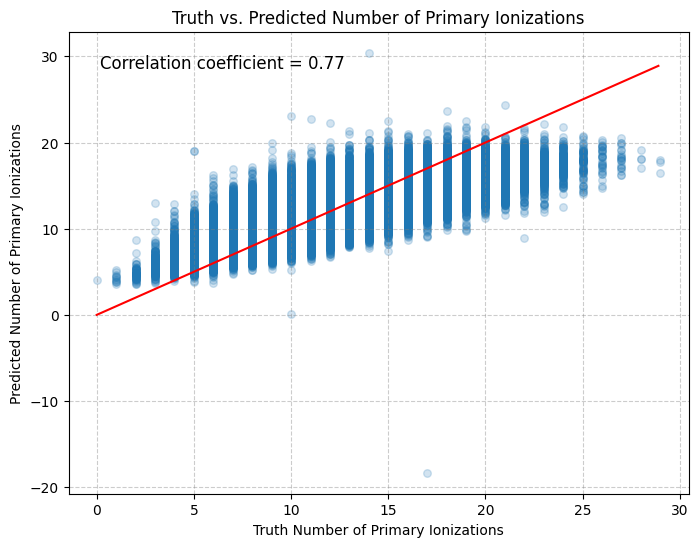

In [47]:
ntest = 100000

plt.figure(figsize=(8, 6), dpi=300)
preds = np.asarray(model.predict(testdata['wf_i']))[:ntest].reshape(ntest)
actual = np.asarray(np.sum(testdata['tag_values'] == 1, axis = 1))[:ntest].reshape(ntest)

make_corr_plot(actual, preds)
plt.savefig('corr_plot.png', dpi=300)



In [215]:
np.sum(actual == 0).astype(np.int32)

1

In [ ]:
testdata['wf_i'].shape

(100000, 500)

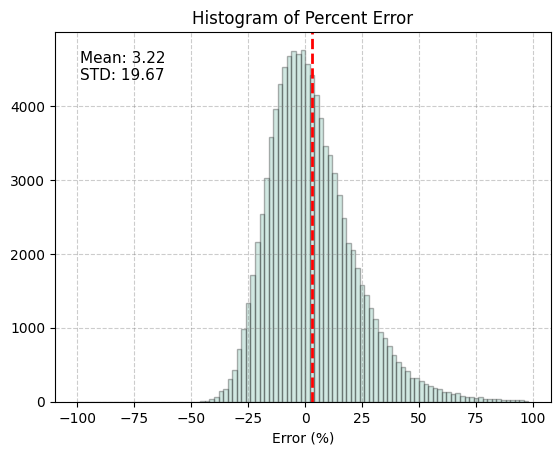

In [25]:
plot_percent_error(actual, preds)

Text(0.5, 1.0, 'Truth vs. Predicted Number of Primary Ionizations')

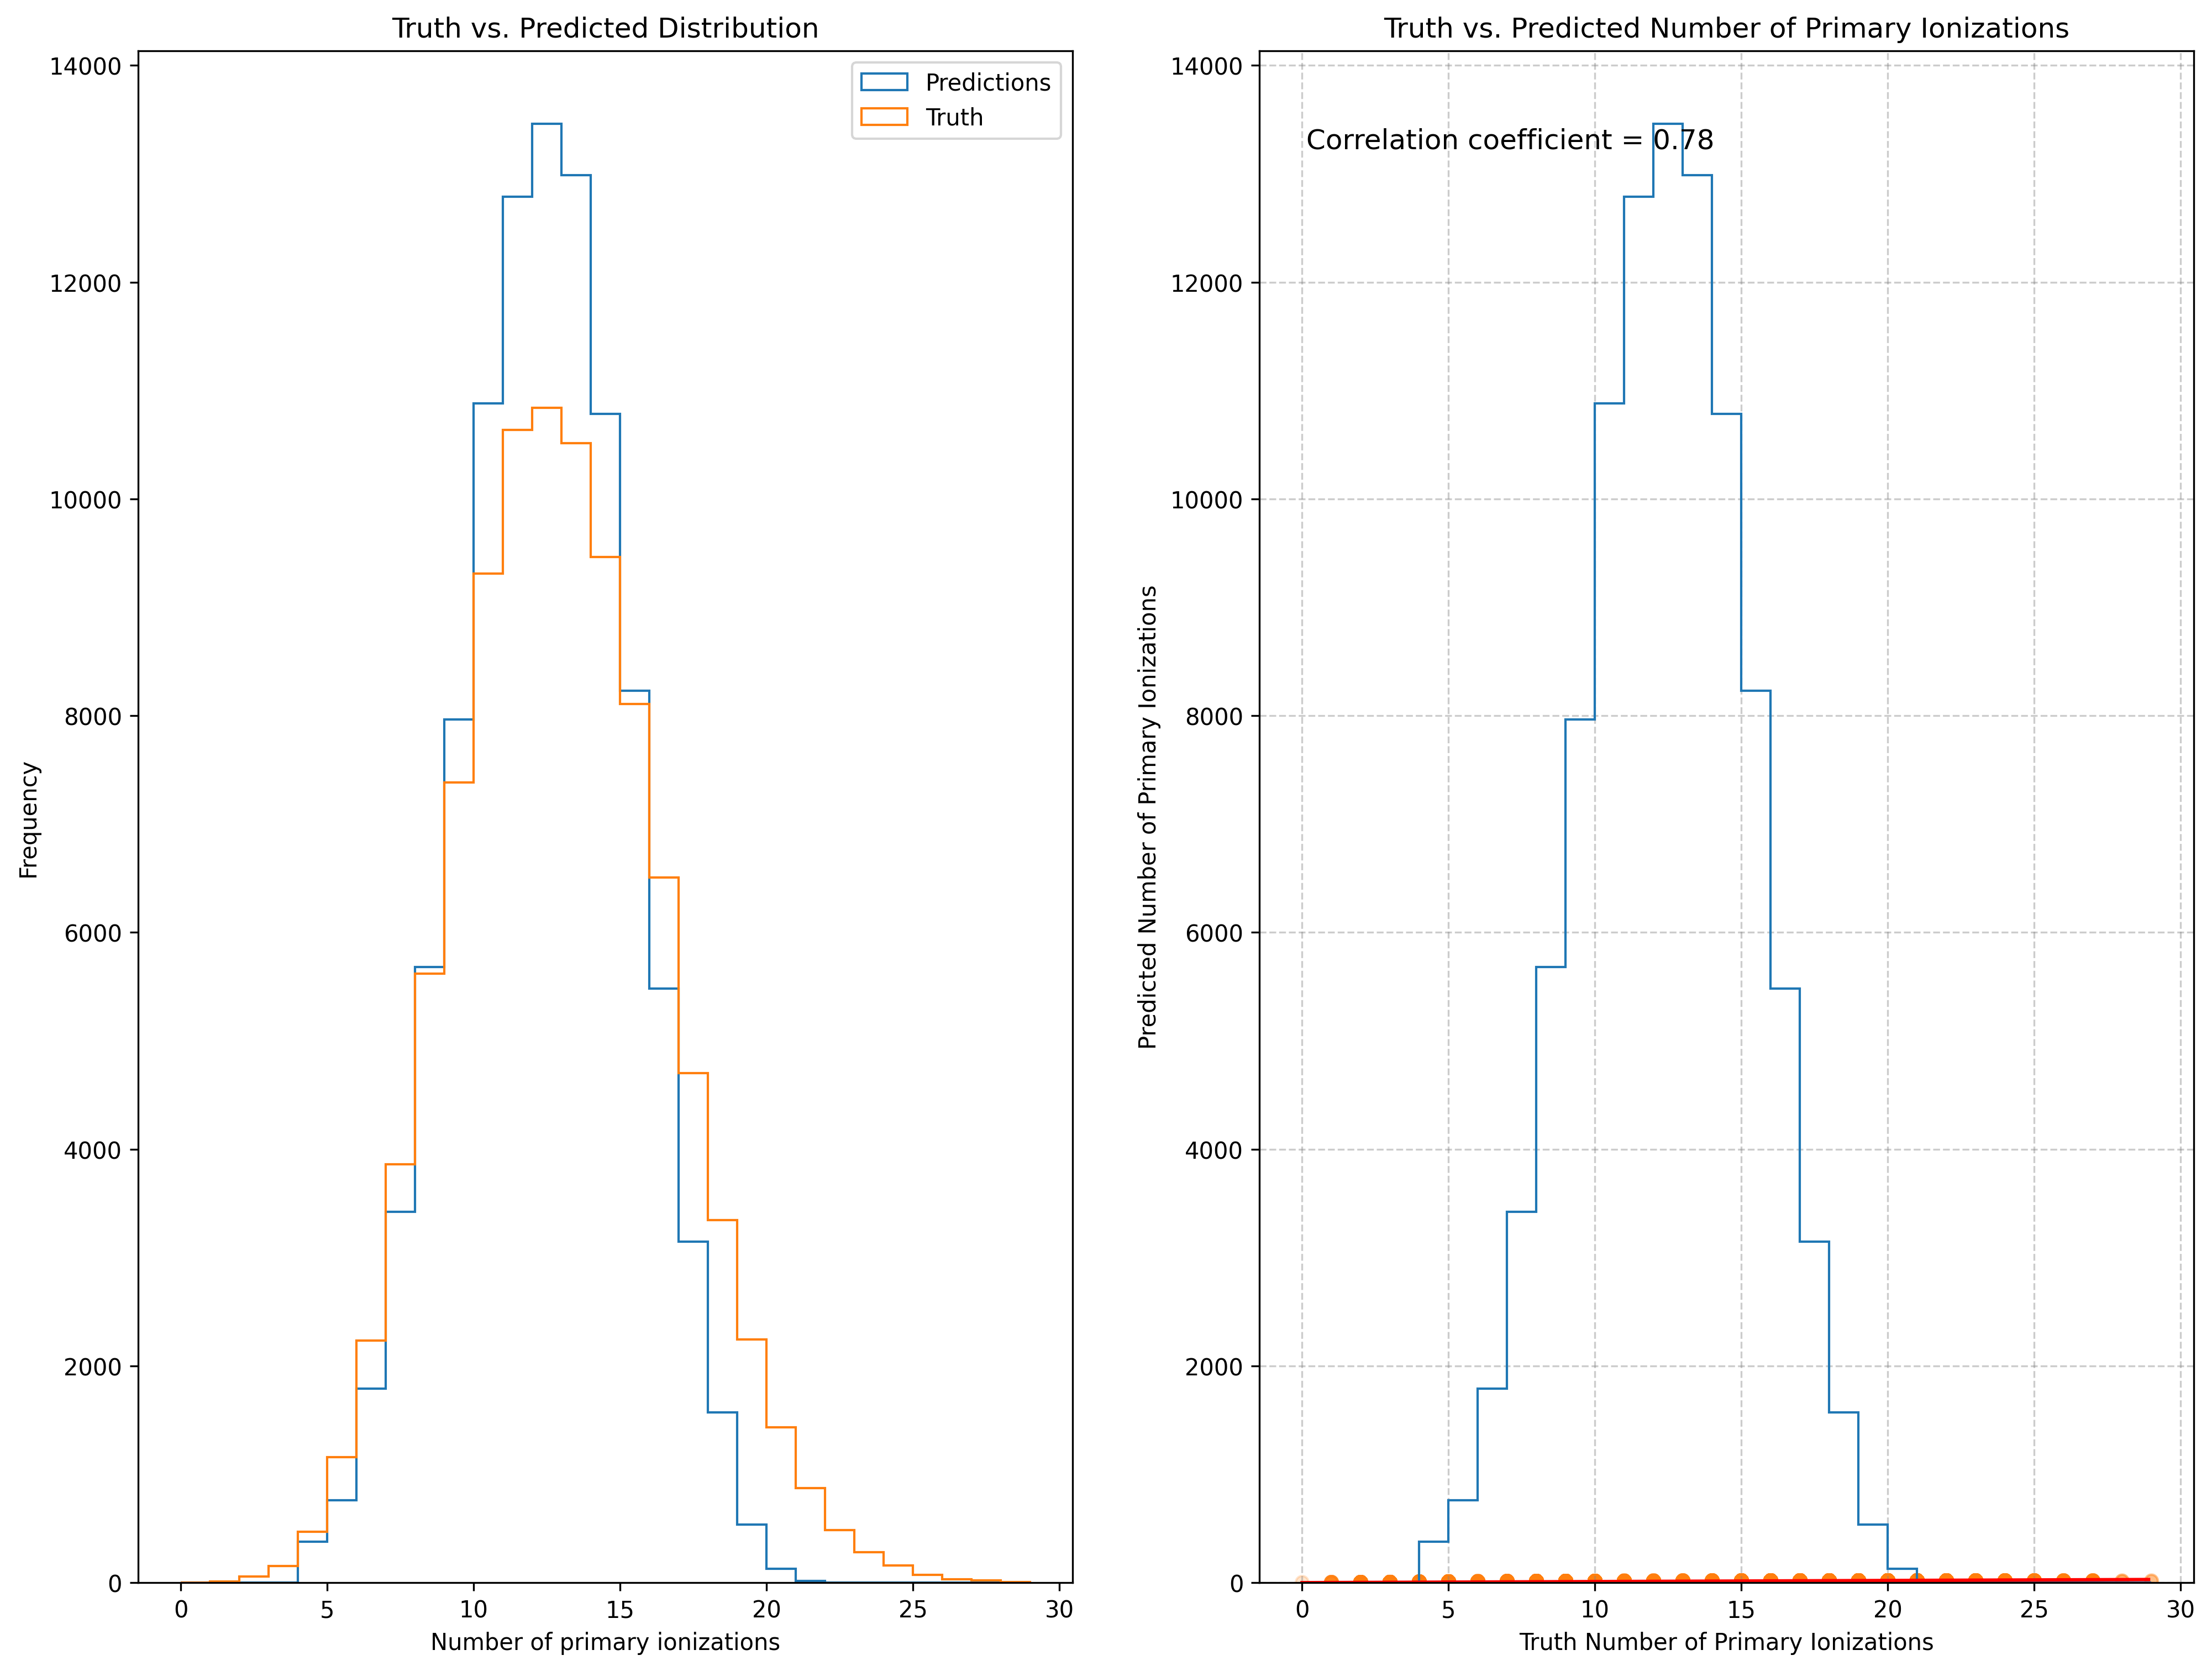

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 12), dpi = 300)

_,bins,_ = plt.hist(preds,bins=np.arange(30),histtype='step',label='Predictions')
axes[0].hist(preds,bins=np.arange(30),histtype='step',label='Predictions')
axes[0].hist(np.sum(testdata['tag_values']==1,axis=-1),bins=bins,histtype='step',label='Truth')
axes[0].legend()
axes[0].set_xlabel("Number of primary ionizations")
axes[0].set_ylabel("Frequency")
axes[0].set_title('Truth vs. Predicted Distribution')


actual = actual
predicted = preds
m = 1
b = 0
correlation_coefficient, p_value = pearsonr(actual[:100000], predicted[:100000])
x = np.arange(actual.min(), actual.max(), step=0.1)

axes[1].scatter(actual, predicted, s=30, alpha=0.2)
axes[1].plot(x, m*x + b, color='red')
axes[1].set_xlabel('Truth Number of Primary Ionizations')
axes[1].set_ylabel('Predicted Number of Primary Ionizations')
axes[1].text(0.05,0.95, f"Correlation coefficient = {correlation_coefficient:.2f}", fontsize=12, color='black', 
            transform=axes[1].transAxes,
            horizontalalignment='left',    
            verticalalignment='top', )
axes[1].grid(True, color='gray', linestyle='--', alpha=0.4)
axes[1].set_title('Truth vs. Predicted Number of Primary Ionizations')



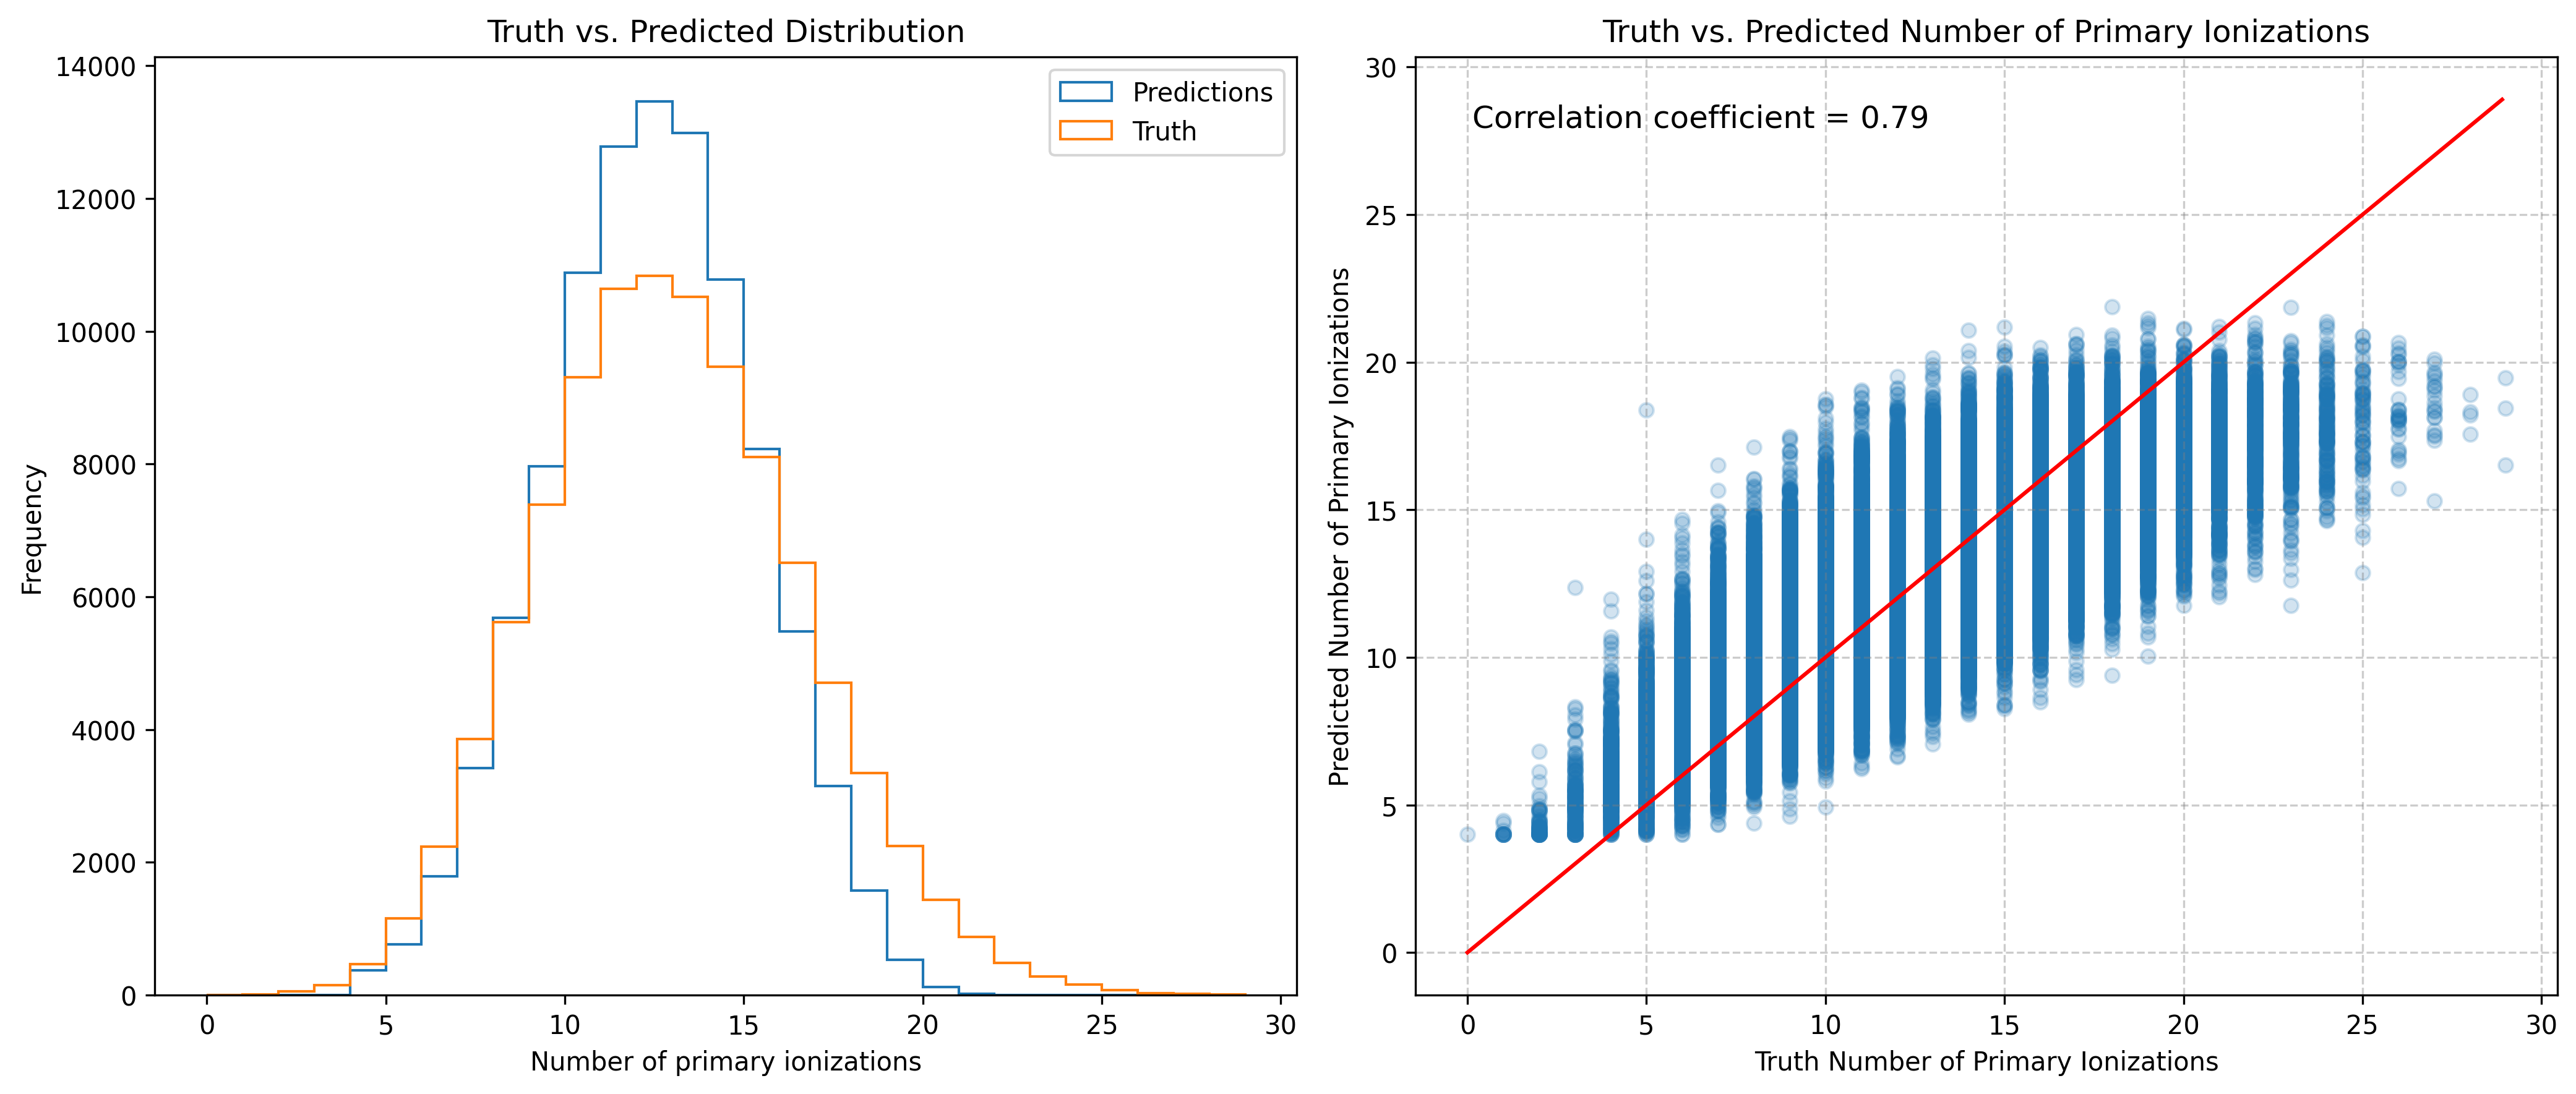

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6), dpi=300)

# Left subplot: Histogram comparison
bins = np.arange(30)
axes[0].hist(preds, bins=bins, histtype='step', label='Predictions')
axes[0].hist(np.sum(testdata['tag_values']==1, axis=-1), bins=bins, histtype='step', label='Truth')
axes[0].legend()
axes[0].set_xlabel("Number of primary ionizations")
axes[0].set_ylabel("Frequency")
axes[0].set_title('Truth vs. Predicted Distribution')

# Right subplot: Correlation scatter plot
actual = np.sum(testdata['tag_values']==1, axis=-1)  # Make sure this matches your truth data
predicted = preds
m = 1
b = 0
correlation_coefficient, p_value = pearsonr(actual[:10000], predicted[:10000])
x = np.arange(actual.min(), actual.max(), step=0.1)

axes[1].scatter(actual, predicted, s=30, alpha=0.2)
axes[1].plot(x, m*x + b, color='red')
axes[1].set_xlabel('Truth Number of Primary Ionizations')
axes[1].set_ylabel('Predicted Number of Primary Ionizations')
axes[1].text(0.05, 0.95, f"Correlation coefficient = {correlation_coefficient:.2f}", 
             fontsize=12, color='black', 
             transform=axes[1].transAxes,
             horizontalalignment='left',    
             verticalalignment='top')
axes[1].grid(True, color='gray', linestyle='--', alpha=0.4)
axes[1].set_title('Truth vs. Predicted Number of Primary Ionizations')

plt.tight_layout()
plt.show()
fig.savefig('model_performance.png')

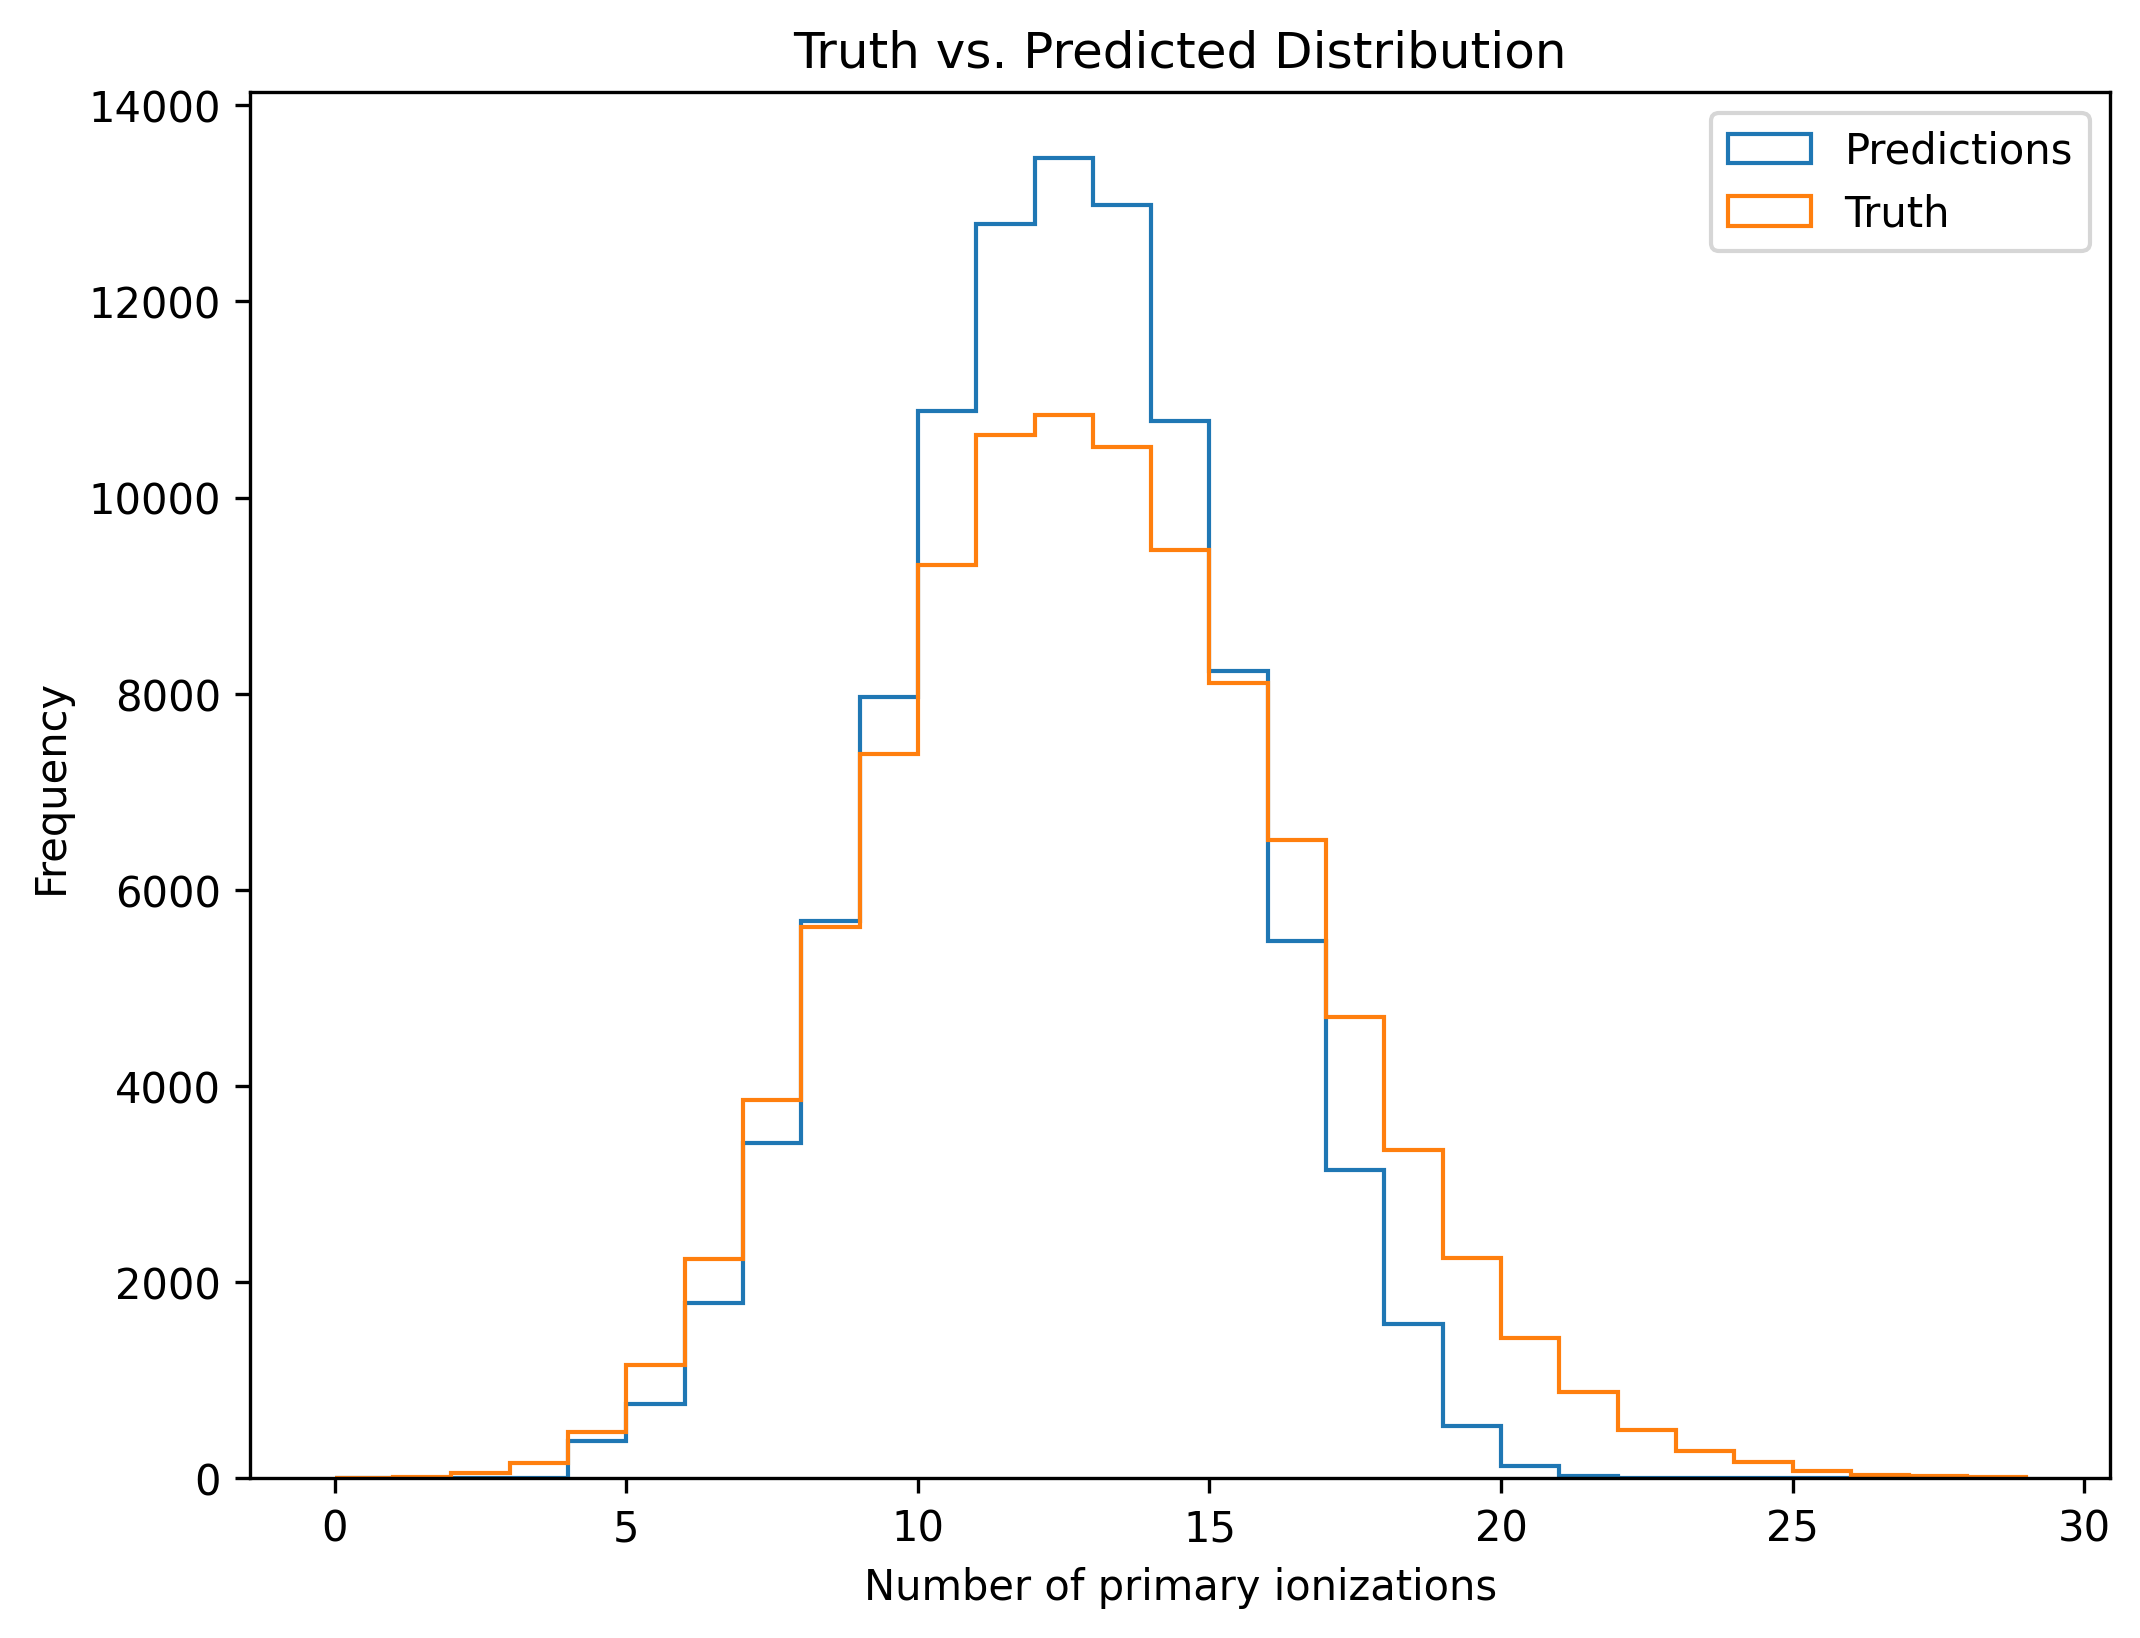

In [42]:
plt.figure(figsize=(8, 6), dpi=300)
_,bins,_ = plt.hist(preds,bins=np.arange(30),histtype='step',label='Predictions')
plt.hist(np.sum(testdata['tag_values']==1,axis=-1),bins=bins,histtype='step',label='Truth')
plt.legend()
plt.xlabel("Number of primary ionizations")
plt.ylabel("Frequency")
plt.title('Truth vs. Predicted Distribution')
plt.savefig('model_distribution.png')

In [42]:
percent_error = 100*(preds - actual)/preds

In [46]:
model.save('models/500_dense_8_32_8.keras')

In [43]:
bins = []
for i in range(actual.min(), actual.max() + 1, 3):
    bins.append(i)

means = []
stds = []
for bin in bins:
    left_edge = bin
    right_edge = bin + 3

    mask = (actual >= left_edge) & (actual < right_edge)

    curr_percent_error = np.asarray(percent_error[mask])
    means.append(np.mean(curr_percent_error))
    stds.append(np.std(curr_percent_error))

bins = np.asarray(bins) + 2


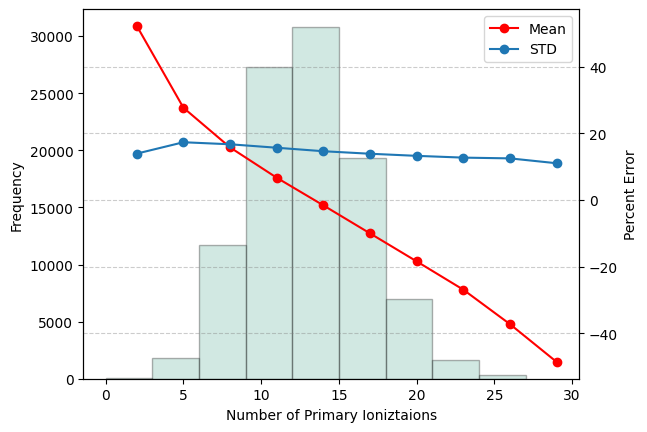

In [44]:
fig, ax1 = plt.subplots()
ax1.hist(actual, histtype='bar', bins=np.arange(actual.min(), actual.max() + 1, 3), edgecolor="black", fc="#69b3a2", alpha=0.3)
ax1.set_ylabel("Frequency")
ax1.set_xlabel("Number of Primary Ioniztaions")

ax2 = ax1.twinx()
ax2.set_ylabel("Percent Error")
ax2.plot(bins, means, marker='o', label='Mean', color= 'r')
ax2.plot(bins, stds, marker='o', label='STD')
plt.grid(True, color='gray', linestyle='--', alpha=0.4)
plt.legend()

# Quantized Version

### Inspecting values of weights

In [93]:
model = keras.models.load_model('models/FINAL_SPECS/500_dense_8_32_8_lr=6e-4.keras')

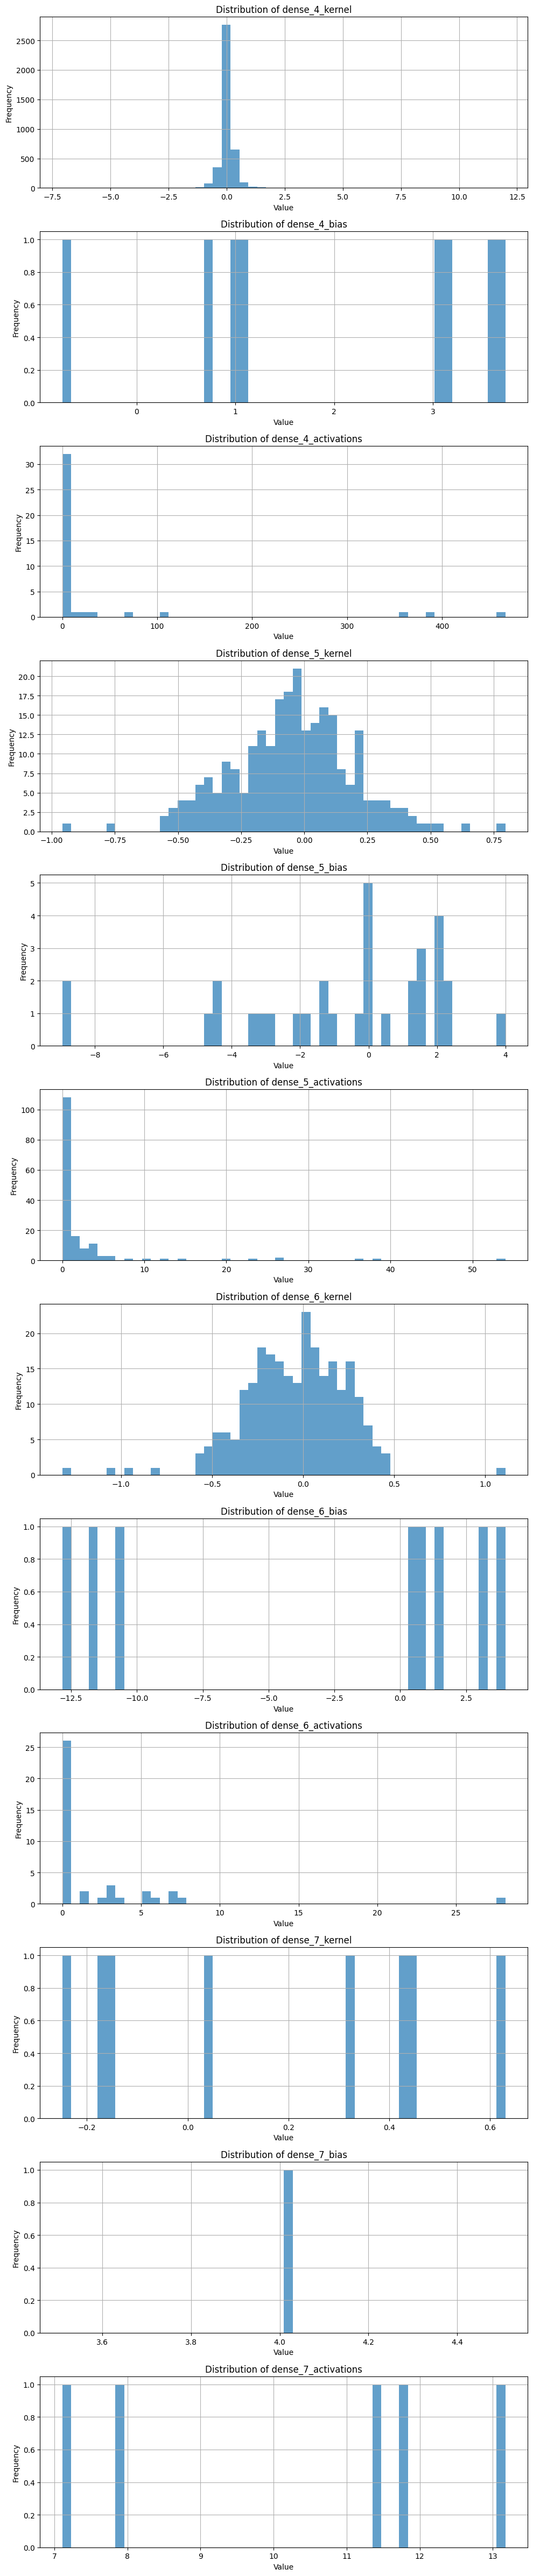

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def plot_distributions(model, X_test, layer_names=None):
    """
    Plots the distributions of weights, biases, and activations for each layer of a Keras model.

    Args:
        model: A trained Keras or QKeras model.
        X_test: A numpy array of test data to generate activation distributions.
        layer_names: An optional list of specific layer names to plot. If None, plots all layers with weights.
    """
    # 1. Get the distributions for all layers
    all_distributions = {}

    for layer in model.layers:
        layer_name = layer.name

        # Check if we should filter by layer name
        if layer_names and layer_name not in layer_names:
            continue

        # Get the weights and biases
        if hasattr(layer, 'weights') and layer.weights:
            for weight_tensor in layer.weights:
                weight_name = weight_tensor.name.split('/')[-1].replace(':0', '')
                data = weight_tensor.numpy().flatten()
                all_distributions[f'{layer_name}_{weight_name}'] = data

        # Get the activations
        if hasattr(layer, 'activation') or isinstance(layer, (tf.keras.layers.Activation)):
            try:
                # Create a temporary model to get the output of the activation layer
                intermediate_model = tf.keras.Model(inputs=model.input, outputs=layer.output)
                activations = intermediate_model.predict(X_test, verbose=0).flatten()
                all_distributions[f'{layer_name}_activations'] = activations
            except Exception as e:
                print(f"Could not get activations for layer {layer_name}. Error: {e}")
                
    # 2. Plot the distributions
    num_plots = len(all_distributions)
    if num_plots == 0:
        print("No distributions to plot.")
        return

    fig, axes = plt.subplots(num_plots, 1, figsize=(10, 4 * num_plots))
    if num_plots == 1:
        axes = [axes]

    for i, (name, data) in enumerate(all_distributions.items()):
        ax = axes[i]
        ax.hist(data, bins=50, alpha=0.7)
        ax.set_title(f'Distribution of {name}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.grid(True)

    plt.tight_layout()
    plt.show()

# # Now, call the function to plot the distributions
plot_distributions(model, testdata['wf_i'][:5])



In [94]:
model.summary()

Model: "DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500)]             0         
                                                                 
 dense_4 (Dense)             (None, 8)                 4008      
                                                                 
 dense_5 (Dense)             (None, 32)                288       
                                                                 
 dense_6 (Dense)             (None, 8)                 264       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 4569 (17.85 KB)
Trainable params: 4569 (17.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# if yes quantization

from qkeras.utils import _add_supported_quantized_objects

co = {}
_add_supported_quantized_objects(co)
model = keras.models.load_model('models/0.6_pruned_q_6_2_regression_dndxgru_focal.h5', custom_objects=co)

In [ ]:
model.layers[1].weights

[<tf.Variable 'q_conv1d/kernel:0' shape=(5, 1, 16) dtype=float32, numpy=
 array([[[ 0.        ,  0.        , -0.9999455 , -0.        ,
           0.        ,  0.        , -0.9538547 , -0.        ,
           0.        , -1.        , -0.        , -0.789478  ,
          -0.78845567, -0.        , -0.        , -1.        ]],
 
        [[ 0.        ,  0.        , -0.9958235 , -0.        ,
          -0.        , -0.7900753 , -0.        , -0.        ,
           0.        , -0.5485872 ,  0.        , -0.7204228 ,
           0.        , -0.7926671 , -0.        , -1.        ]],
 
        [[-0.        ,  0.        , -1.        , -0.        ,
          -0.        , -0.8634212 ,  0.7425956 , -0.9927945 ,
          -0.        , -0.7470194 ,  0.        , -0.849759  ,
           0.        , -0.        , -0.        , -0.9992576 ]],
 
        [[-0.        ,  0.        , -1.        , -0.7858454 ,
          -0.        ,  0.        ,  0.7935626 , -0.        ,
          -0.        , -0.74745476, -0.        

['q_conv1d', 'q_conv1d_1', 'q_conv1d_2', 'q_dense', 'q_dense_1', 'q_dense_2']
[[0.0, 0.0, -0.9999455, -0.0, 0.0, 0.0, -0.9538547, -0.0, 0.0, -1.0, -0.0, -0.789478, -0.78845567, -0.0, -0.0, -1.0, 0.0, 0.0, -0.9958235, -0.0, -0.0, -0.7900753, -0.0, -0.0, 0.0, -0.5485872, 0.0, -0.7204228, 0.0, -0.7926671, -0.0, -1.0, -0.0, 0.0, -1.0, -0.0, -0.0, -0.8634212, 0.7425956, -0.9927945, -0.0, -0.7470194, 0.0, -0.849759, 0.0, -0.0, -0.0, -0.9992576, -0.0, 0.0, -1.0, -0.7858454, -0.0, 0.0, 0.7935626, -0.0, -0.0, -0.74745476, -0.0, -0.8179518, 0.0, -0.0, -0.0, -0.9875926, -0.0, -0.0, -0.9990397, -0.85140944, -0.0, -0.0, -0.0, 0.8300034, -1.0, -0.99992937, -0.0, -0.53013206, 0.9523007, -0.0, -0.0, 0.0, -1.0, 0.61041886, 0.16650285, 0.9980264, -0.18763848, -0.19649717, -0.32808888, -0.046036735, -0.9918767, 0.21496667, -0.08728536, 0.859147, -0.14101695, 0.9952886, -0.7477933, 0.17405133], [-0.0, 0.4919762, 0.0, -0.0, 0.0, -0.0, -1.9860157, -0.0, 0.490939, -0.8391804, -1.4532541, -1.6596742, -0.75319

/tmp/ipykernel_3973230/2359277035.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(layer_weights, vert = False, patch_artist=True, labels = layer_names)


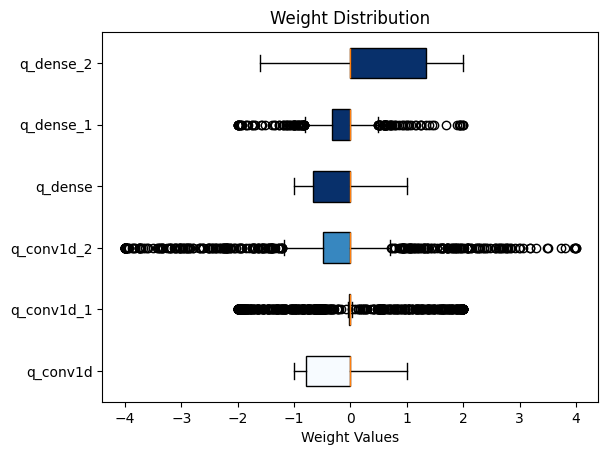

In [ ]:
box_plot_weights(model)
    

% of zeros = 0.5925925925925926


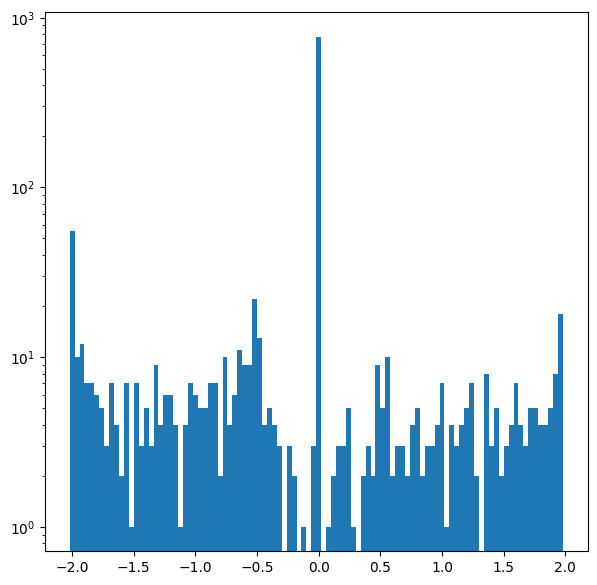

In [ ]:
w = []
flatten_list(model.layers[2].get_weights(), w)
w = np.asarray(w)
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7, 7))
plt.bar(b[:-1], h, width=b[1] - b[0])
plt.semilogy()
print('% of zeros = {}'.format(np.sum(w == 0) / np.size(w)))

In [ ]:
len(layer_weights)

8

### Attempt #1

In [ ]:
from keras.layers import Input, GlobalAveragePooling1D, Reshape, MaxPooling1D
from qkeras import *

b_w = 6
i = 2


def create_model(c1layers=[[32,1,1,'valid',False]],
             dlayers=[32,32]):
    inputs = Input(shape=(3000,1))
    x = inputs
    npool = 0
    for i,c in enumerate(c1layers):
        x = QConv1D(c[0],c[1],c[2],padding=c[3], kernel_quantizer=quantized_bits(b_w, i, alpha=1),
        bias_quantizer=quantized_bits(b_w, i, alpha=1))(x)
        x = QActivation(activation=quantized_relu(b_w, i))(x)
        if c[4]:
            x = MaxPooling1D(2)(x)
            npool = npool+1
    
    x = GlobalAveragePooling1D()(x)
    
    for i,d in enumerate(dlayers):
        x = QDense(d, kernel_quantizer=quantized_bits(b_w,i,1),
           bias_quantizer=quantized_bits(b_w,i,1))(x)
        x = QActivation(activation=quantized_relu(b_w, i))(x)    
    

    x = QDense(1,kernel_quantizer=quantized_bits(b_w,i,1),
           bias_quantizer=quantized_bits(b_w,i,1))(x)

    x = QActivation("quantized_bits(20, 5)")(x)
    x = Activation("linear")(x)

    outputs = x
    
    return keras.Model(inputs=inputs, outputs=outputs, name="gru")
 
 
c1layers=[[16,5,5,'valid',False],[16,5,1,'same',False],[16,5,1,'same',False]]
dlayers=[32, 32]
model = create_model(c1layers, dlayers)
 
print(model.summary())

Model: "gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3000, 1)]         0         
                                                                 
 q_conv1d (QConv1D)          (None, 600, 16)           96        
                                                                 
 q_activation (QActivation)  (None, 600, 16)           0         
                                                                 
 q_conv1d_1 (QConv1D)        (None, 600, 16)           1296      
                                                                 
 q_activation_1 (QActivatio  (None, 600, 16)           0         
 n)                                                              
                                                                 
 q_conv1d_2 (QConv1D)        (None, 600, 16)           1296      
                                                               

In [ ]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.optimizers import Adam

from qkeras import *

b_w = 6
i = 2

loss_fn = tf.keras.losses.MeanSquaredError()
batchSize = 64
nEpochs = 2
learningRate = 1e-3

earlystop = EarlyStopping(
        monitor="val_loss", 
        patience=10,
        restore_best_weights=True,
        min_delta=0.0, 
    )

reducelr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_delta=0.,
    min_lr=1.e-7,
)

print(model.summary())
# Define Optimizer and compile
opt = Adam(learning_rate=learningRate)
model.compile(loss=loss_fn, optimizer=opt,
    metrics=tf.keras.metrics.MeanAbsoluteError(name='mae'))


history = model.fit(train_ds, validation_data=val_ds,
                    batch_size=batchSize, epochs=nEpochs, callbacks=(earlystop,reducelr))

model.save('models/v2_q_6_2_regression_dndxgru_focal.h5')
# model = keras.models.load_model('models/dndxgru_%s.keras'%(label+grulabel))

Model: "gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3000, 1)]         0         
                                                                 
 q_conv1d (QConv1D)          (None, 600, 16)           96        
                                                                 
 q_activation (QActivation)  (None, 600, 16)           0         
                                                                 
 q_conv1d_1 (QConv1D)        (None, 600, 16)           1296      
                                                                 
 q_activation_1 (QActivatio  (None, 600, 16)           0         
 n)                                                              
                                                                 
 q_conv1d_2 (QConv1D)        (None, 600, 16)           1296      
                                                               

ValueError: in user code:

    File "/u1/dyilmaz/conda/envs/hls4ml_alt_CEPC/lib/python3.10/site-packages/keras/src/engine/training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "/u1/dyilmaz/conda/envs/hls4ml_alt_CEPC/lib/python3.10/site-packages/keras/src/engine/training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/u1/dyilmaz/conda/envs/hls4ml_alt_CEPC/lib/python3.10/site-packages/keras/src/engine/training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "/u1/dyilmaz/conda/envs/hls4ml_alt_CEPC/lib/python3.10/site-packages/keras/src/engine/training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "/u1/dyilmaz/conda/envs/hls4ml_alt_CEPC/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/u1/dyilmaz/conda/envs/hls4ml_alt_CEPC/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "gru" is incompatible with the layer: expected shape=(None, 3000, 1), found shape=(None, 300, 1)


### Attempt #2

In [ ]:
from keras.layers import Input, GlobalAveragePooling1D, Reshape, MaxPooling1D
from qkeras import *

b_w = 6
i = 0


def create_model(c1layers=[[32,1,1,'valid',False]],
             dlayers=[32,32]):
    inputs = Input(shape=(3000,1))
    x = inputs
    npool = 0
    for i,c in enumerate(c1layers):
        x = QConv1D(c[0],c[1],c[2],padding=c[3], kernel_quantizer=quantized_bits(b_w, i, alpha=1),
        bias_quantizer=quantized_bits(b_w, i, alpha=1))(x)
        x = QActivation(activation=quantized_relu(b_w, i))(x)
        if c[4]:
            x = MaxPooling1D(2)(x)
            npool = npool+1
    
    # x = GlobalAveragePooling1D()(x)
    
    for i,d in enumerate(dlayers):
        x = QDense(d, kernel_quantizer=quantized_bits(b_w,i,1),
           bias_quantizer=quantized_bits(b_w,i,1))(x)
        x = QActivation(activation=quantized_relu(b_w, i))(x)    
    

    x = QDense(1,kernel_quantizer=quantized_bits(b_w,i,1),
           bias_quantizer=quantized_bits(b_w,i,1))(x)

    # x = QActivation("quantized_bits(20, 5)")(x)
    x = Activation("linear")(x)

    outputs = x
    
    return keras.Model(inputs=inputs, outputs=outputs, name="gru")
 
 
c1layers=[[16,5,5,'valid',False],[16,5,1,'same',False],[16,5,1,'same',False]]
dlayers=[32, 32]
model = create_model(c1layers, dlayers)
 
print(model.summary())

### Attempt 3 (downsampled quantized version)

In [1]:
from keras.layers import Input, GlobalAveragePooling1D, Reshape, MaxPooling1D
from qkeras import *

b_w = 8
i = 2


def create_model(c1layers=[[32,1,1,'valid',False]],
             dlayers=[32,32]):
    inputs = Input(shape=(int(3000),1))
    x = inputs
    npool = 0
    for i,c in enumerate(c1layers):
        x = QConv1D(c[0],c[1],c[2],padding=c[3], kernel_quantizer=quantized_bits(b_w, i, alpha=1),
        bias_quantizer=quantized_bits(b_w, i, alpha=1), activation='relu')(x)
        # x = QActivation(activation=quantized_relu(b_w, i))(x)
        if c[4]:
            x = MaxPooling1D(2)(x)
            npool = npool+1
    
    x = GlobalAveragePooling1D()(x)
    
    for i,d in enumerate(dlayers):
        x = QDense(d, kernel_quantizer=quantized_bits(b_w,i,1),
           bias_quantizer=quantized_bits(b_w,i,1), activation='relu')(x)
        # x = QActivation(activation=quantized_relu(b_w, i))(x)    
    

    x = QDense(1,kernel_quantizer=quantized_bits(b_w,i,1),
           bias_quantizer=quantized_bits(b_w,i,1))(x)

    # x = QActivation("quantized_bits(20, 5)")(x)
    x = Activation("linear")(x)

    outputs = x
    
    return keras.Model(inputs=inputs, outputs=outputs, name="gru")
 
 
c1layers=[[16,5,5,'valid',False],[16,5,1,'same',False],[16,5,1,'same',False]]
dlayers=[32, 32]
model = create_model(c1layers, dlayers)
 
print(model.summary())

2025-08-25 14:13:54.545215: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-25 14:13:54.637951: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3000, 1)]         0         
                                                                 
 q_conv1d (QConv1D)          (None, 600, 16)           96        
                                                                 
 q_conv1d_1 (QConv1D)        (None, 600, 16)           1296      
                                                                 
 q_conv1d_2 (QConv1D)        (None, 600, 16)           1296      
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 q_dense (QDense)            (None, 32)                544       
                                                               

In [ ]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.optimizers import Adam

from qkeras import *

b_w = 8
i = 2

loss_fn = tf.keras.losses.MeanSquaredError()
batchSize = 64
nEpochs = 2
learningRate = 1e-2

earlystop = EarlyStopping(
        monitor="val_loss", 
        patience=10,
        restore_best_weights=True,
        min_delta=0.0, 
    )

reducelr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_delta=0.,
    min_lr=1.e-7,
)

print(model.summary())
# Define Optimizer and compile
opt = Adam(learning_rate=learningRate)
model.compile(loss=loss_fn, optimizer=opt,
    metrics=tf.keras.metrics.MeanAbsoluteError(name='mae'))

if doGRUTrain:
    history = model.fit(train_ds, validation_data=val_ds,
                      batch_size=batchSize, epochs=nEpochs, callbacks=(earlystop,reducelr))

    model.save('models/v2_q_6_2_regression_dndxgru_focal.h5')
else:
    model = keras.models.load_model('models/dndxgru_%s.keras'%(label+grulabel))

Model: "gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 3000, 1)]         0         
                                                                 
 q_conv1d_9 (QConv1D)        (None, 600, 16)           96        
                                                                 
 q_conv1d_10 (QConv1D)       (None, 600, 16)           1296      
                                                                 
 q_conv1d_11 (QConv1D)       (None, 600, 16)           1296      
                                                                 
 global_average_pooling1d_3  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 q_dense_9 (QDense)          (None, 32)                544       
                                                               

/u1/dyilmaz/conda/envs/hls4ml_alt_CEPC/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/u1/dyilmaz/conda/envs/hls4ml_alt_CEPC/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [ ]:
model.save('models/q_8_2_cf_10.h5')

### Attempt 4 (only dense, downsampled)

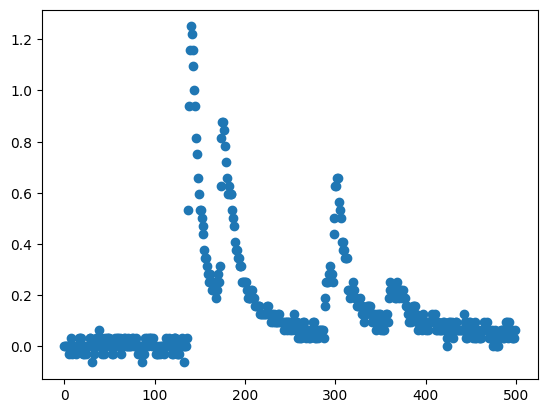

In [97]:
input_quantizer = quantized_bits(16, 10, symmetric=0)
input_quantizer(testdata['wf_i'][0]).numpy()

plt.scatter(np.arange(500), input_quantizer(testdata['wf_i'][0]).numpy())

In [98]:
import keras
from keras.layers import Dense, Input, AveragePooling1D, Reshape, GlobalAveragePooling1D, MaxPooling1D, Flatten
from qkeras import *

b_w = 16
i = 0

kernel_bias_quantizer = quantized_bits(8, 4, symmetric=1)
relu_quantizer = quantized_relu(8, 4)
linear_quantizer = quantized_bits(8, 6)
input_quantizer = quantized_bits(16, 10)

def create_model():
    inputs = Input(shape=(int(num_timepoints/compress_factor),))
    x = inputs

    x = QActivation(input_quantizer)(x)

    x = QDense(8, kernel_quantizer=kernel_bias_quantizer,
        bias_quantizer=kernel_bias_quantizer)(x)
    
    x = QActivation(relu_quantizer)(x)

    x = QDense(32, kernel_quantizer=kernel_bias_quantizer,
        bias_quantizer=kernel_bias_quantizer)(x)
    
    x = QActivation(relu_quantizer)(x)

    x = QDense(8, kernel_quantizer=kernel_bias_quantizer,
        bias_quantizer=kernel_bias_quantizer)(x)
    
    x = QActivation(relu_quantizer)(x)

    x = QDense(1,kernel_quantizer=kernel_bias_quantizer,
        bias_quantizer=kernel_bias_quantizer)(x)
    
    x = QActivation(linear_quantizer)(x)
    
    outputs = x

    return keras.Model(inputs=inputs, outputs=outputs, name="DNN")


In [101]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.optimizers import Adam

from qkeras import *

loss_fn = tf.keras.losses.MeanSquaredError()
batchSize = 64
nEpochs = 75
learningRate = 3e-4

earlystop = EarlyStopping(
        monitor="val_loss", 
        patience=10,
        restore_best_weights=True,
        min_delta=0.0, 
    )

reducelr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_delta=0.,
    min_lr=1.e-7,
)

model = create_model()

print(model.summary())
# Define Optimizer and compile
opt = Adam(learning_rate=learningRate)
model.compile(loss=loss_fn, optimizer=opt,
    metrics=tf.keras.metrics.MeanAbsoluteError(name='mae'))

if doGRUTrain:
    history = model.fit(train_ds, validation_data=val_ds,
                      batch_size=batchSize, epochs=nEpochs, callbacks=(earlystop,reducelr))

    model.save('models/8_16_10_500_dense_8_32_8_lr=1e-4.h5')
else:
    model = keras.models.load_model('models/dndxgru_%s.keras'%(label+grulabel))

Model: "DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 500)]             0         
                                                                 
 q_activation_30 (QActivati  (None, 500)               0         
 on)                                                             
                                                                 
 q_dense_24 (QDense)         (None, 8)                 4008      
                                                                 
 q_activation_31 (QActivati  (None, 8)                 0         
 on)                                                             
                                                                 
 q_dense_25 (QDense)         (None, 32)                288       
                                                                 
 q_activation_32 (QActivati  (None, 32)                0       

/u1/dyilmaz/conda/envs/hls4ml_alt_CEPC/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/u1/dyilmaz/conda/envs/hls4ml_alt_CEPC/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [65]:
testdata['wf_i'].max()

587.177

In [35]:
model.save('models/16_5_500_dense_8_32_8_lr=4e-4.h5')

In [41]:
b_w = 8
i = 2
mse = []

def create_and_train(lr):
    model = create_model(b_w, i)

    loss_fn = tf.keras.losses.MeanSquaredError()
    batchSize = 64
    nEpochs = 10
    learningRate = lr

    earlystop = EarlyStopping(
            monitor="val_loss", 
            patience=10,
            restore_best_weights=True,
            min_delta=0.0, 
        )

    reducelr = ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=3,
        min_delta=0.,
        min_lr=1.e-7,
    )

    print(model.summary())
    # Define Optimizer and compile
    opt = Adam(learning_rate=learningRate)
    model.compile(loss=loss_fn, optimizer=opt,
        metrics=tf.keras.metrics.MeanAbsoluteError(name='mae'))


    history = model.fit(train_ds, validation_data=val_ds,
        batch_size=batchSize, epochs=nEpochs, callbacks=(earlystop,reducelr))
  
    return model

learningRates = [1e-5, 4e-5, 5e-5, 6e-5, 7e-5, 8e-5, 9e-5, 1e-4, 2e-4, 3e-4, 4e-4, 5e-4]
mse = []

for lr in learningRates:
    print(f"Training model with learning rate: {lr}")
    model = create_and_train(lr)
    model.save(f'models/q_500_dense_8_32_8_lr_{lr}.keras')
    print(f"Model saved for learning rate: {lr}")
    mse.append(model.evaluate(val_ds, verbose=0)[0])


Training model with learning rate: 1e-05
Model: "DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 500)]             0         
                                                                 
 q_dense_52 (QDense)         (None, 8)                 4008      
                                                                 
 q_dense_53 (QDense)         (None, 32)                288       
                                                                 
 q_dense_54 (QDense)         (None, 8)                 264       
                                                                 
 q_dense_55 (QDense)         (None, 1)                 9         
                                                                 
Total params: 4569 (17.85 KB)
Trainable params: 4569 (17.85 KB)
Non-trainable params: 0 (0.00 Byte)
______________________________________________________

2025-08-25 15:52:26.690655: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1 of 512
2025-08-25 15:52:26.731551: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


6250/6250 [==============================] - 57s 6ms/step - loss: 146.5494 - mae: 11.1634 - val_loss: 139.1335 - val_mae: 10.7448 - lr: 1.0000e-05
Epoch 2/10
6250/6250 [==============================] - 35s 5ms/step - loss: 128.2395 - mae: 10.2986 - val_loss: 120.3366 - val_mae: 10.0103 - lr: 1.0000e-05
Epoch 3/10
6250/6250 [==============================] - 43s 6ms/step - loss: 107.7385 - mae: 9.3244 - val_loss: 96.8603 - val_mae: 8.7864 - lr: 1.0000e-05
Epoch 4/10
6250/6250 [==============================] - 40s 5ms/step - loss: 84.5718 - mae: 8.0696 - val_loss: 73.7920 - val_mae: 7.4650 - lr: 1.0000e-05
Epoch 5/10
6250/6250 [==============================] - 36s 5ms/step - loss: 60.2254 - mae: 6.5971 - val_loss: 51.4783 - val_mae: 5.8998 - lr: 1.0000e-05
Epoch 6/10
6250/6250 [==============================] - 35s 5ms/step - loss: 40.0688 - mae: 5.0999 - val_loss: 32.6266 - val_mae: 4.4748 - lr: 1.0000e-05
Epoch 7/10
6250/6250 [==============================] - 36s 5ms/step - loss: 2

/u1/dyilmaz/conda/envs/hls4ml_alt_CEPC/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


Model saved for learning rate: 1e-05
Training model with learning rate: 4e-05
Model: "DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 500)]             0         
                                                                 
 q_dense_56 (QDense)         (None, 8)                 4008      
                                                                 
 q_dense_57 (QDense)         (None, 32)                288       
                                                                 
 q_dense_58 (QDense)         (None, 8)                 264       
                                                                 
 q_dense_59 (QDense)         (None, 1)                 9         
                                                                 
Total params: 4569 (17.85 KB)
Trainable params: 4569 (17.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________

2025-08-25 16:22:30.880125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 1 of 512
2025-08-25 16:22:30.885211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


6250/6250 [==============================] - 44s 6ms/step - loss: 6.8365 - mae: 1.9951 - val_loss: 6.7330 - val_mae: 1.9933 - lr: 7.0000e-05
Epoch 9/10
6250/6250 [==============================] - 36s 5ms/step - loss: 6.8128 - mae: 1.9811 - val_loss: 6.3463 - val_mae: 1.9583 - lr: 7.0000e-05
Epoch 10/10
6250/6250 [==============================] - 35s 5ms/step - loss: 6.6962 - mae: 1.9735 - val_loss: 7.3574 - val_mae: 2.0188 - lr: 7.0000e-05
Model saved for learning rate: 7e-05
Training model with learning rate: 8e-05
Model: "DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 500)]             0         
                                                                 
 q_dense_72 (QDense)         (None, 8)                 4008      
                                                                 
 q_dense_73 (QDense)         (None, 32)                288       
 

2025-08-25 16:57:50.177620: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1 of 512
2025-08-25 16:57:50.182735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


6250/6250 [==============================] - 46s 6ms/step - loss: 6.6541 - mae: 1.9796 - val_loss: 6.3156 - val_mae: 1.9430 - lr: 4.0000e-04
Epoch 6/10
6250/6250 [==============================] - 40s 5ms/step - loss: 6.5205 - mae: 1.9635 - val_loss: 6.1377 - val_mae: 1.9237 - lr: 4.0000e-04
Epoch 7/10
6250/6250 [==============================] - 36s 5ms/step - loss: 6.2159 - mae: 1.9340 - val_loss: 6.0104 - val_mae: 1.9078 - lr: 4.0000e-04
Epoch 8/10
6250/6250 [==============================] - 36s 5ms/step - loss: 6.0479 - mae: 1.9165 - val_loss: 5.9371 - val_mae: 1.9109 - lr: 4.0000e-04
Epoch 9/10
6250/6250 [==============================] - 35s 5ms/step - loss: 6.0568 - mae: 1.9163 - val_loss: 5.8514 - val_mae: 1.8869 - lr: 4.0000e-04
Epoch 10/10
6250/6250 [==============================] - 36s 5ms/step - loss: 6.2076 - mae: 1.9245 - val_loss: 5.7656 - val_mae: 1.8799 - lr: 4.0000e-04
Model saved for learning rate: 0.0004
Training model with learning rate: 0.0005
Model: "DNN"
_____

2025-08-25 17:02:02.867141: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1 of 512
2025-08-25 17:02:02.872816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


6250/6250 [==============================] - 93s 11ms/step - loss: 30.8010 - mae: 3.4762 - val_loss: 11.5006 - val_mae: 2.4738 - lr: 5.0000e-04
Epoch 2/10
6250/6250 [==============================] - 36s 5ms/step - loss: 10.3798 - mae: 2.2793 - val_loss: 7.2696 - val_mae: 2.0897 - lr: 5.0000e-04
Epoch 3/10
6171/6250 [============================>.] - ETA: 0s - loss: 7.4174 - mae: 2.0573

2025-08-25 17:04:27.833256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 1 of 512
2025-08-25 17:04:27.837896: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


6250/6250 [==============================] - 41s 6ms/step - loss: 7.4090 - mae: 2.0570 - val_loss: 6.7323 - val_mae: 2.0172 - lr: 5.0000e-04
Epoch 4/10
6250/6250 [==============================] - 35s 5ms/step - loss: 7.1940 - mae: 2.0304 - val_loss: 6.3075 - val_mae: 1.9598 - lr: 5.0000e-04
Epoch 5/10
6250/6250 [==============================] - 36s 5ms/step - loss: 6.6811 - mae: 1.9880 - val_loss: 6.3545 - val_mae: 1.9536 - lr: 5.0000e-04
Epoch 6/10
6191/6250 [============================>.] - ETA: 0s - loss: 6.7310 - mae: 1.9765

2025-08-25 17:06:23.703786: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 1 of 512
2025-08-25 17:06:23.708313: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


6250/6250 [==============================] - 45s 6ms/step - loss: 6.7305 - mae: 1.9769 - val_loss: 6.5684 - val_mae: 1.9702 - lr: 5.0000e-04
Epoch 7/10
 256/6250 [>.............................] - ETA: 3s - loss: 6.7690 - mae: 1.9898     

2025-08-25 17:06:46.116905: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1 of 512
2025-08-25 17:06:46.121352: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


6250/6250 [==============================] - 144s 20ms/step - loss: 6.6127 - mae: 1.9685 - val_loss: 6.3013 - val_mae: 1.9465 - lr: 5.0000e-04
Epoch 8/10
6250/6250 [==============================] - 29s 4ms/step - loss: 7.1040 - mae: 2.0046 - val_loss: 6.5038 - val_mae: 1.9583 - lr: 5.0000e-04
Epoch 9/10
6250/6250 [==============================] - 23s 3ms/step - loss: 6.4489 - mae: 1.9489 - val_loss: 5.9765 - val_mae: 1.9123 - lr: 5.0000e-04
Epoch 10/10
6250/6250 [==============================] - 23s 3ms/step - loss: 6.1259 - mae: 1.9217 - val_loss: 6.0847 - val_mae: 1.9169 - lr: 5.0000e-04
Model saved for learning rate: 0.0005


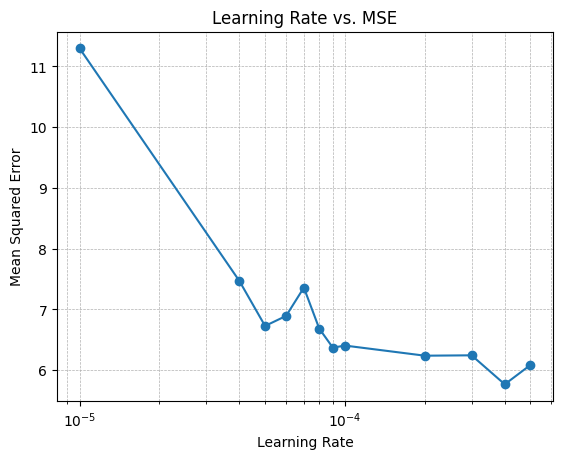

In [42]:
import matplotlib.pyplot as plt
# learningRates = [1e-2, 3.16e-3, 1e-3, 3.16e-4, 1e-4, 3.16e-5, 1e-5, 3.16e-6, 1e-6]
plt.plot(learningRates, mse, marker='o')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Squared Error')
plt.title('Learning Rate vs. MSE')
plt.grid(True, which='both', linestyle='--', linewidth=0.5) 

In [40]:
mse

[139.18580627441406,
 127.26596069335938,
 11.615091323852539,
 8.101387977600098,
 7.046105861663818,
 6.026363849639893,
 5.6668901443481445,
 6.676748275756836,
 7.321873188018799]

In [30]:
model.save('models/8_2_500_dense_8_32_8_lr=1e-4.h5')

In [33]:
# quantization script

bit_values = [[16,4], [16,2], [16,0], [8,4], [8,2], [8,0], [6,2], [6,0], [4,0]]

for bit_value in bit_values:
    model = create_model(bit_value[0], bit_value[1])

    loss_fn = tf.keras.losses.MeanSquaredError()
    batchSize = 64
    nEpochs = 25
    learningRate = 1e-2

    earlystop = EarlyStopping(
            monitor="val_loss", 
            patience=10,
            restore_best_weights=True,
            min_delta=0.0, 
        )

    reducelr = ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=3,
        min_delta=0.,
        min_lr=1.e-7,
    )

    print(model.summary())
    # Define Optimizer and compile
    opt = Adam(learning_rate=learningRate)
    model.compile(loss=loss_fn, optimizer=opt,
        metrics=tf.keras.metrics.MeanAbsoluteError(name='mae'))

    history = model.fit(train_ds, validation_data=val_ds,
                        batch_size=batchSize, epochs=nEpochs, callbacks=(earlystop,reducelr))

    name = 'models/500_quantized_8_32_8/' + str(bit_value[0]) + '_' + str(bit_value[1])
    model.save(name)

    

Model: "DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 500)]             0         
                                                                 
 q_dense_11 (QDense)         (None, 8)                 4008      
                                                                 
 q_dense_12 (QDense)         (None, 32)                288       
                                                                 
 q_dense_13 (QDense)         (None, 8)                 264       
                                                                 
 q_dense_14 (QDense)         (None, 1)                 9         
                                                                 
Total params: 4569 (17.85 KB)
Trainable params: 4569 (17.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25


6250/6250 [==============================] - 24s 3ms/step - loss: 14.6667 - mae: 2.9122 - val_loss: 7.9507 - val_mae: 2.2020 - lr: 0.0100
Epoch 2/25
6250/6250 [==============================] - 23s 3ms/step - loss: 8.0862 - mae: 2.2195 - val_loss: 8.3607 - val_mae: 2.2432 - lr: 0.0100
Epoch 3/25
6250/6250 [==============================] - 24s 3ms/step - loss: 8.1189 - mae: 2.2232 - val_loss: 7.7844 - val_mae: 2.1732 - lr: 0.0100
Epoch 4/25
6250/6250 [==============================] - 22s 3ms/step - loss: 8.1012 - mae: 2.2216 - val_loss: 10.2309 - val_mae: 2.5911 - lr: 0.0100
Epoch 5/25
6250/6250 [==============================] - 23s 3ms/step - loss: 8.2305 - mae: 2.2413 - val_loss: 7.7211 - val_mae: 2.1621 - lr: 0.0100
Epoch 6/25
6250/6250 [==============================] - 22s 3ms/step - loss: 8.2060 - mae: 2.2368 - val_loss: 7.7624 - val_mae: 2.1674 - lr: 0.0100
Epoch 7/25
6250/6250 [==============================] - 23s 3ms/step - loss: 8.2004 - mae: 2.2359 - val_loss: 7.5416 - va

INFO:tensorflow:Assets written to: models/500_quantized_8_32_8/16_4/assets


Model: "DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 500)]             0         
                                                                 
 q_dense_15 (QDense)         (None, 8)                 4008      
                                                                 
 q_dense_16 (QDense)         (None, 32)                288       
                                                                 
 q_dense_17 (QDense)         (None, 8)                 264       
                                                                 
 q_dense_18 (QDense)         (None, 1)                 9         
                                                                 
Total params: 4569 (17.85 KB)
Trainable params: 4569 (17.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25


/u1/dyilmaz/conda/envs/hls4ml_alt_CEPC/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


6250/6250 [==============================] - 24s 3ms/step - loss: 17.0145 - mae: 2.4871 - val_loss: 8.1736 - val_mae: 2.2206 - lr: 0.0100
Epoch 2/25
6250/6250 [==============================] - 23s 3ms/step - loss: 8.7005 - mae: 2.2491 - val_loss: 7.9547 - val_mae: 2.1915 - lr: 0.0100
Epoch 3/25
6250/6250 [==============================] - 23s 3ms/step - loss: 8.3597 - mae: 2.2599 - val_loss: 8.4994 - val_mae: 2.2887 - lr: 0.0100
Epoch 4/25
6250/6250 [==============================] - 23s 3ms/step - loss: 8.6775 - mae: 2.3069 - val_loss: 7.9322 - val_mae: 2.1988 - lr: 0.0100
Epoch 5/25
6250/6250 [==============================] - 24s 3ms/step - loss: 8.5211 - mae: 2.2806 - val_loss: 9.3823 - val_mae: 2.4285 - lr: 0.0100
Epoch 6/25
6250/6250 [==============================] - 23s 3ms/step - loss: 8.7280 - mae: 2.2947 - val_loss: 8.0242 - val_mae: 2.2107 - lr: 0.0100
Epoch 7/25
6250/6250 [==============================] - 23s 3ms/step - loss: 12.5626 - mae: 2.5721 - val_loss: 12.0420 - v

INFO:tensorflow:Assets written to: models/500_quantized_8_32_8/16_2/assets


Model: "DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 500)]             0         
                                                                 
 q_dense_19 (QDense)         (None, 8)                 4008      
                                                                 
 q_dense_20 (QDense)         (None, 32)                288       
                                                                 
 q_dense_21 (QDense)         (None, 8)                 264       
                                                                 
 q_dense_22 (QDense)         (None, 1)                 9         
                                                                 
Total params: 4569 (17.85 KB)
Trainable params: 4569 (17.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25


/u1/dyilmaz/conda/envs/hls4ml_alt_CEPC/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


6250/6250 [==============================] - 24s 3ms/step - loss: 24.0733 - mae: 3.3894 - val_loss: 13.3728 - val_mae: 2.9311 - lr: 0.0100
Epoch 2/25
6250/6250 [==============================] - 23s 3ms/step - loss: 13.4884 - mae: 2.9300 - val_loss: 13.5839 - val_mae: 2.9133 - lr: 0.0100
Epoch 3/25
6250/6250 [==============================] - 23s 3ms/step - loss: 13.4604 - mae: 2.9308 - val_loss: 13.6717 - val_mae: 2.9177 - lr: 0.0100
Epoch 4/25
6250/6250 [==============================] - 22s 3ms/step - loss: 13.4519 - mae: 2.9295 - val_loss: 13.9425 - val_mae: 2.9608 - lr: 0.0100
Epoch 5/25
6250/6250 [==============================] - 23s 3ms/step - loss: 13.4809 - mae: 2.9280 - val_loss: 13.3914 - val_mae: 2.9218 - lr: 0.0020
Epoch 6/25
6250/6250 [==============================] - 23s 3ms/step - loss: 13.3696 - mae: 2.9256 - val_loss: 13.3828 - val_mae: 2.9203 - lr: 0.0020
Epoch 7/25
6250/6250 [==============================] - 23s 3ms/step - loss: 13.3486 - mae: 2.9243 - val_loss: 

INFO:tensorflow:Assets written to: models/500_quantized_8_32_8/16_0/assets


Model: "DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 500)]             0         
                                                                 
 q_dense_23 (QDense)         (None, 8)                 4008      
                                                                 
 q_dense_24 (QDense)         (None, 32)                288       
                                                                 
 q_dense_25 (QDense)         (None, 8)                 264       
                                                                 
 q_dense_26 (QDense)         (None, 1)                 9         
                                                                 
Total params: 4569 (17.85 KB)
Trainable params: 4569 (17.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25


/u1/dyilmaz/conda/envs/hls4ml_alt_CEPC/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


6250/6250 [==============================] - 23s 3ms/step - loss: 12.9877 - mae: 2.7309 - val_loss: 8.2538 - val_mae: 2.2304 - lr: 0.0100
Epoch 2/25
6250/6250 [==============================] - 24s 3ms/step - loss: 20.5170 - mae: 2.2468 - val_loss: 7.9781 - val_mae: 2.1918 - lr: 0.0100
Epoch 3/25
6250/6250 [==============================] - 23s 3ms/step - loss: 8.0718 - mae: 2.2186 - val_loss: 8.1716 - val_mae: 2.2255 - lr: 0.0100
Epoch 4/25
6250/6250 [==============================] - 23s 3ms/step - loss: 8.1352 - mae: 2.2163 - val_loss: 7.9567 - val_mae: 2.2015 - lr: 0.0100
Epoch 5/25
6250/6250 [==============================] - 23s 3ms/step - loss: 8.2560 - mae: 2.2411 - val_loss: 7.8334 - val_mae: 2.1792 - lr: 0.0100
Epoch 6/25
6250/6250 [==============================] - 24s 3ms/step - loss: 8.0952 - mae: 2.2213 - val_loss: 8.4299 - val_mae: 2.2767 - lr: 0.0100
Epoch 7/25
6250/6250 [==============================] - 24s 3ms/step - loss: 8.2342 - mae: 2.2402 - val_loss: 9.4666 - va

INFO:tensorflow:Assets written to: models/500_quantized_8_32_8/8_4/assets


Model: "DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 500)]             0         
                                                                 
 q_dense_27 (QDense)         (None, 8)                 4008      
                                                                 
 q_dense_28 (QDense)         (None, 32)                288       
                                                                 
 q_dense_29 (QDense)         (None, 8)                 264       
                                                                 
 q_dense_30 (QDense)         (None, 1)                 9         
                                                                 
Total params: 4569 (17.85 KB)
Trainable params: 4569 (17.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25


/u1/dyilmaz/conda/envs/hls4ml_alt_CEPC/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


6250/6250 [==============================] - 24s 3ms/step - loss: 18.0023 - mae: 3.0593 - val_loss: 13.3885 - val_mae: 2.9251 - lr: 0.0100
Epoch 2/25
6250/6250 [==============================] - 24s 3ms/step - loss: 12.6876 - mae: 2.8341 - val_loss: 8.2217 - val_mae: 2.2451 - lr: 0.0100
Epoch 3/25
6250/6250 [==============================] - 23s 3ms/step - loss: 8.5056 - mae: 2.2838 - val_loss: 8.1464 - val_mae: 2.2307 - lr: 0.0100
Epoch 4/25
6250/6250 [==============================] - 23s 3ms/step - loss: 8.5338 - mae: 2.2882 - val_loss: 8.1273 - val_mae: 2.2339 - lr: 0.0100
Epoch 5/25
6250/6250 [==============================] - 23s 3ms/step - loss: 8.4579 - mae: 2.2776 - val_loss: 10.6058 - val_mae: 2.5699 - lr: 0.0100
Epoch 6/25
6250/6250 [==============================] - 23s 3ms/step - loss: 8.5321 - mae: 2.2881 - val_loss: 8.2115 - val_mae: 2.2403 - lr: 0.0100
Epoch 7/25
6250/6250 [==============================] - 23s 3ms/step - loss: 8.6686 - mae: 2.3071 - val_loss: 7.9196 - 

INFO:tensorflow:Assets written to: models/500_quantized_8_32_8/8_2/assets


Model: "DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 500)]             0         
                                                                 
 q_dense_31 (QDense)         (None, 8)                 4008      
                                                                 
 q_dense_32 (QDense)         (None, 32)                288       
                                                                 
 q_dense_33 (QDense)         (None, 8)                 264       
                                                                 
 q_dense_34 (QDense)         (None, 1)                 9         
                                                                 
Total params: 4569 (17.85 KB)
Trainable params: 4569 (17.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25


/u1/dyilmaz/conda/envs/hls4ml_alt_CEPC/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


6250/6250 [==============================] - 24s 3ms/step - loss: 15.1678 - mae: 2.9590 - val_loss: 13.3586 - val_mae: 2.9262 - lr: 0.0100
Epoch 2/25
6250/6250 [==============================] - 23s 3ms/step - loss: 13.8039 - mae: 2.9302 - val_loss: 13.3710 - val_mae: 2.9262 - lr: 0.0100
Epoch 3/25
6250/6250 [==============================] - 23s 3ms/step - loss: 13.4361 - mae: 2.9288 - val_loss: 13.8652 - val_mae: 2.9513 - lr: 0.0100
Epoch 4/25
6250/6250 [==============================] - 23s 3ms/step - loss: 13.4756 - mae: 2.9290 - val_loss: 13.4807 - val_mae: 2.9395 - lr: 0.0100
Epoch 5/25
6250/6250 [==============================] - 23s 3ms/step - loss: 13.3838 - mae: 2.9276 - val_loss: 13.3622 - val_mae: 2.9237 - lr: 0.0020
Epoch 6/25
6250/6250 [==============================] - 24s 3ms/step - loss: 13.3396 - mae: 2.9235 - val_loss: 13.4415 - val_mae: 2.9172 - lr: 0.0020
Epoch 7/25
6250/6250 [==============================] - 23s 3ms/step - loss: 13.2832 - mae: 2.9171 - val_loss: 

INFO:tensorflow:Assets written to: models/500_quantized_8_32_8/8_0/assets


Model: "DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 500)]             0         
                                                                 
 q_dense_35 (QDense)         (None, 8)                 4008      
                                                                 
 q_dense_36 (QDense)         (None, 32)                288       
                                                                 
 q_dense_37 (QDense)         (None, 8)                 264       
                                                                 
 q_dense_38 (QDense)         (None, 1)                 9         
                                                                 
Total params: 4569 (17.85 KB)
Trainable params: 4569 (17.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25


/u1/dyilmaz/conda/envs/hls4ml_alt_CEPC/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


6250/6250 [==============================] - 23s 3ms/step - loss: 21.7707 - mae: 3.0385 - val_loss: 13.4164 - val_mae: 2.9228 - lr: 0.0100
Epoch 2/25
6250/6250 [==============================] - 23s 3ms/step - loss: 13.5034 - mae: 2.9341 - val_loss: 14.7695 - val_mae: 3.0393 - lr: 0.0100
Epoch 3/25
6250/6250 [==============================] - 24s 3ms/step - loss: 13.4486 - mae: 2.9309 - val_loss: 14.1185 - val_mae: 2.9811 - lr: 0.0100
Epoch 4/25
6250/6250 [==============================] - 23s 3ms/step - loss: 13.3050 - mae: 2.9060 - val_loss: 12.7443 - val_mae: 2.8421 - lr: 0.0100
Epoch 5/25
6250/6250 [==============================] - 24s 3ms/step - loss: 12.9331 - mae: 2.8704 - val_loss: 12.5103 - val_mae: 2.8074 - lr: 0.0100
Epoch 6/25
6250/6250 [==============================] - 23s 3ms/step - loss: 12.9565 - mae: 2.8727 - val_loss: 12.5050 - val_mae: 2.8110 - lr: 0.0100
Epoch 7/25
6250/6250 [==============================] - 23s 3ms/step - loss: 12.6966 - mae: 2.8414 - val_loss: 

INFO:tensorflow:Assets written to: models/500_quantized_8_32_8/6_2/assets


Model: "DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 500)]             0         
                                                                 
 q_dense_39 (QDense)         (None, 8)                 4008      
                                                                 
 q_dense_40 (QDense)         (None, 32)                288       
                                                                 
 q_dense_41 (QDense)         (None, 8)                 264       
                                                                 
 q_dense_42 (QDense)         (None, 1)                 9         
                                                                 
Total params: 4569 (17.85 KB)
Trainable params: 4569 (17.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25


/u1/dyilmaz/conda/envs/hls4ml_alt_CEPC/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


6250/6250 [==============================] - 24s 3ms/step - loss: 27.5438 - mae: 3.3783 - val_loss: 13.5319 - val_mae: 2.9321 - lr: 0.0100
Epoch 2/25
6250/6250 [==============================] - 23s 3ms/step - loss: 13.4208 - mae: 2.9303 - val_loss: 13.5469 - val_mae: 2.9131 - lr: 0.0100
Epoch 3/25
6250/6250 [==============================] - 22s 3ms/step - loss: 13.9560 - mae: 2.9314 - val_loss: 13.3691 - val_mae: 2.9263 - lr: 0.0100
Epoch 4/25
6250/6250 [==============================] - 23s 3ms/step - loss: 13.4360 - mae: 2.9291 - val_loss: 13.4646 - val_mae: 2.9183 - lr: 0.0100
Epoch 5/25
6250/6250 [==============================] - 23s 3ms/step - loss: 13.4279 - mae: 2.9287 - val_loss: 13.3931 - val_mae: 2.9229 - lr: 0.0100
Epoch 6/25
6250/6250 [==============================] - 23s 3ms/step - loss: 13.4202 - mae: 2.9283 - val_loss: 13.4495 - val_mae: 2.9184 - lr: 0.0100
Epoch 7/25
6250/6250 [==============================] - 22s 3ms/step - loss: 13.3643 - mae: 2.9249 - val_loss: 

INFO:tensorflow:Assets written to: models/500_quantized_8_32_8/6_0/assets


Model: "DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 500)]             0         
                                                                 
 q_dense_43 (QDense)         (None, 8)                 4008      
                                                                 
 q_dense_44 (QDense)         (None, 32)                288       
                                                                 
 q_dense_45 (QDense)         (None, 8)                 264       
                                                                 
 q_dense_46 (QDense)         (None, 1)                 9         
                                                                 
Total params: 4569 (17.85 KB)
Trainable params: 4569 (17.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25


/u1/dyilmaz/conda/envs/hls4ml_alt_CEPC/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


6250/6250 [==============================] - 23s 3ms/step - loss: 26.0919 - mae: 3.5497 - val_loss: 13.3702 - val_mae: 2.9258 - lr: 0.0100
Epoch 2/25
6250/6250 [==============================] - 24s 3ms/step - loss: 13.4133 - mae: 2.9292 - val_loss: 13.3861 - val_mae: 2.9241 - lr: 0.0100
Epoch 3/25
6250/6250 [==============================] - 23s 3ms/step - loss: 13.4758 - mae: 2.9305 - val_loss: 13.7211 - val_mae: 2.9305 - lr: 0.0100
Epoch 4/25
6250/6250 [==============================] - 23s 3ms/step - loss: 13.3891 - mae: 2.9291 - val_loss: 13.3661 - val_mae: 2.9301 - lr: 0.0100
Epoch 5/25
6250/6250 [==============================] - 23s 3ms/step - loss: 13.9616 - mae: 2.9356 - val_loss: 13.3637 - val_mae: 2.9276 - lr: 0.0100
Epoch 6/25
6250/6250 [==============================] - 23s 3ms/step - loss: 13.4127 - mae: 2.9289 - val_loss: 13.3763 - val_mae: 2.9238 - lr: 0.0100
Epoch 7/25
6250/6250 [==============================] - 23s 3ms/step - loss: 13.3742 - mae: 2.9284 - val_loss: 

INFO:tensorflow:Assets written to: models/500_quantized_8_32_8/4_0/assets
/u1/dyilmaz/conda/envs/hls4ml_alt_CEPC/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [27]:
quantized_model_dir = 'models/500_quantized_8_32_8/'
model_paths = os.listdir('models/500_quantized_8_32_8/')

In [28]:
means = []
stds = []

for model_path in model_paths:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects

    co = {}
    _add_supported_quantized_objects(co)
    model = load_model(quantized_model_dir + model_path, custom_objects=co)

    def compute_error(model_path, ntest):
        model = keras.models.load_model(model_path)

        preds = model.predict(testdata['wf_i'])
        actual = np.sum(testdata['tag_values'] == 1, axis = 1)

        preds = np.asarray(preds.astype(np.float16))[:ntest].reshape(ntest)
        actual = np.asarray(actual.astype(np.float16))[:ntest].reshape(ntest)

        error = ((preds - actual)/actual) * 100

        mean = np.mean(error)
        std = np.std(error.astype(np.float32))

        return mean, std
    
    mean, std = compute_error(quantized_model_dir + model_path, 10000)

    means.append(mean)
    stds.append(std)
    

3125/3125 [==============================] - 1s 355us/step


3125/3125 [==============================] - 1s 349us/step


3125/3125 [==============================] - 1s 336us/step


3125/3125 [==============================] - 1s 306us/step


3125/3125 [==============================] - 1s 343us/step


3125/3125 [==============================] - 1s 333us/step


3125/3125 [==============================] - 1s 346us/step


3125/3125 [==============================] - 1s 330us/step


3125/3125 [==============================] - 1s 406us/step


Text(0.5, 1.0, 'Quantization vs. Mean Percent Error')

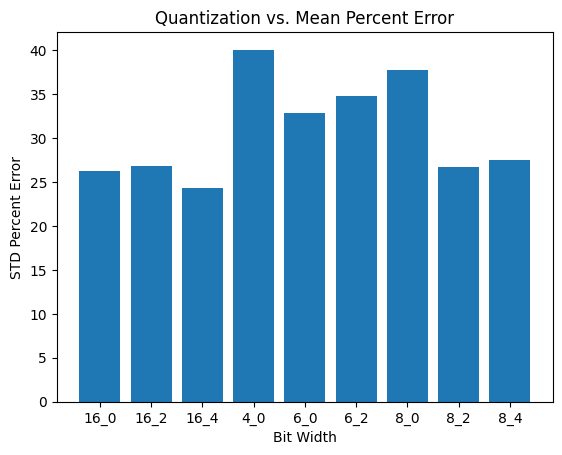

In [ ]:
plt.bar(np.sort(model_paths), np.asarray(stds)[np.argsort(model_paths)])
plt.xlabel('Bit Width')
plt.ylabel('STD Percent Error')
plt.title('Quantization vs. STD Percent Error')

In [29]:
# original_models = ['16_2', '8_2', '6_0', '4_0', '16_4', '8_4', '6_2', '16_0', '8_0']
# original_errors = [0.12, 0.25, 0.45, 0.51, 0.10, 0.23, 0.40, 0.18, 0.30]

model_error_map = dict(zip(model_paths, stds))
# model_error_map will look like: {'16_2': 0.12, '8_2': 0.25, ...}

In [30]:
desired_order = ['16_4', '16_2', '16_0', '8_4', '8_2', '8_0', '6_2', '6_0', '4_0']

# Create the new list of errors based on the desired order
reordered_errors = [model_error_map[model] for model in desired_order]

print(reordered_errors)

[24.257515, 26.785295, 26.273106, 27.499882, 26.699675, 37.680428, 34.82262, 32.846428, 40.035187]


Text(0.5, 1.0, 'Quantization vs. STD Percent Error')

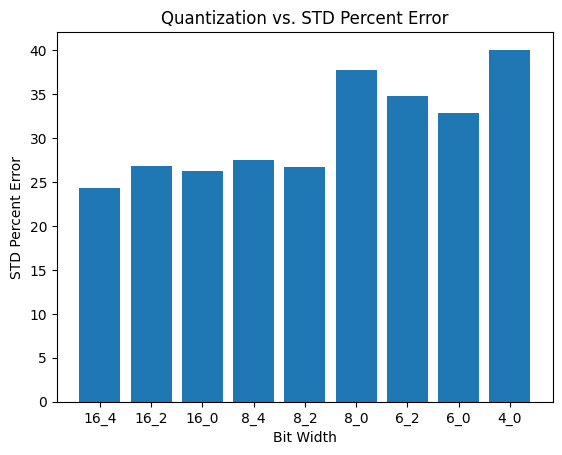

In [31]:
plt.bar(desired_order, reordered_errors)
plt.xlabel('Bit Width')
plt.ylabel('STD Percent Error')
plt.title('Quantization vs. STD Percent Error')

# Pruning

In [ ]:
# load model
import keras
og_model_path = "models/8_2500_dense_8_32_8_lr=1e-4.keras"
model = keras.models.load_model(og_model_path)

OSError: No file or directory found at models/500_dense_8_32_8_lr=1e-4.keras

In [120]:
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

co = {}
_add_supported_quantized_objects(co)
model = load_model('models/8_16_10_500_dense_8_32_8_lr=1e-4.h5', custom_objects=co)

In [102]:
model.summary()

Model: "DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 500)]             0         
                                                                 
 q_activation_30 (QActivati  (None, 500)               0         
 on)                                                             
                                                                 
 q_dense_24 (QDense)         (None, 8)                 4008      
                                                                 
 q_activation_31 (QActivati  (None, 8)                 0         
 on)                                                             
                                                                 
 q_dense_25 (QDense)         (None, 32)                288       
                                                                 
 q_activation_32 (QActivati  (None, 32)                0       

In [ ]:
epochs = 5
learningRate = 1e-3
batchSize = 64
loss_fn = tf.keras.losses.MeanSquaredError()
ntest = 100000

In [ ]:
model = keras.models.load_model('models/10_5')

In [121]:
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.optimizers import Adam

import tempfile

epochs = 25
learningRate = 6e-4
batchSize = 64
loss_fn = tf.keras.losses.MeanSquaredError()
ntest = 100000
sparsity = 0.65

model_for_pruning = model

pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(sparsity, begin_step=0, frequency=100)}
model_for_pruning = prune.prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
opt = Adam(learning_rate=learningRate)
model_for_pruning.compile(optimizer=opt,
            loss=loss_fn,
            metrics=tf.keras.metrics.MeanAbsoluteError(name='mae'))

model_for_pruning.summary()

logdir = tempfile.mkdtemp()

reducelr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_delta=0.,
    min_lr=1.e-7,
)

callbacks = [
tfmot.sparsity.keras.UpdatePruningStep(),
tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

history = model_for_pruning.fit(train_ds, validation_data=val_ds,
                    batch_size=batchSize, epochs=epochs, callbacks=(callbacks, reducelr))

model_for_pruning = strip_pruning(model_for_pruning)

model_for_pruning.save('models/8_16_19_0.7_pruned_500_dense_8_32_8_lr=4e-4.h5')


Model: "DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 500)]             0         
                                                                 
 prune_low_magnitude_q_acti  (None, 500)               1         
 vation_30 (PruneLowMagnitu                                      
 de)                                                             
                                                                 
 prune_low_magnitude_q_dens  (None, 8)                 8010      
 e_24 (PruneLowMagnitude)                                        
                                                                 
 prune_low_magnitude_q_acti  (None, 8)                 1         
 vation_31 (PruneLowMagnitu                                      
 de)                                                             
                                                               

6250/6250 [==============================] - 32s 4ms/step - loss: 10.0263 - mae: 2.2667 - val_loss: 6.0148 - val_mae: 1.9157 - lr: 6.0000e-04
Epoch 2/25
6250/6250 [==============================] - 29s 4ms/step - loss: 5.9735 - mae: 1.9098 - val_loss: 5.8387 - val_mae: 1.8868 - lr: 6.0000e-04
Epoch 3/25
6250/6250 [==============================] - 29s 4ms/step - loss: 5.8601 - mae: 1.8925 - val_loss: 5.7622 - val_mae: 1.8739 - lr: 6.0000e-04
Epoch 4/25
6250/6250 [==============================] - 28s 4ms/step - loss: 5.7783 - mae: 1.8789 - val_loss: 5.6799 - val_mae: 1.8616 - lr: 6.0000e-04
Epoch 5/25
6250/6250 [==============================] - 29s 4ms/step - loss: 5.7271 - mae: 1.8708 - val_loss: 5.6363 - val_mae: 1.8564 - lr: 6.0000e-04
Epoch 6/25
6250/6250 [==============================] - 28s 4ms/step - loss: 5.6915 - mae: 1.8656 - val_loss: 5.6154 - val_mae: 1.8536 - lr: 6.0000e-04
Epoch 7/25
6250/6250 [==============================] - 29s 4ms/step - loss: 5.6710 - mae: 1.8619 

In [122]:
model_for_pruning.save('models/8_16_19_0.65_pruned_500_dense_8_32_8_lr=4e-4.h5')

In [39]:
model_for_pruning.save('models/16_5_0.6_pruned_500_dense_8_32_8_lr=4e-4.h5')

In [33]:
model = model_for_pruning

In [ ]:
model_for_pruning.save('models/0.6_pruned_q_8_2_cf_10.h5')

In [ ]:
model = keras.models.load_model('models/curr/cf_30_tiny_dense.keras')

In [ ]:
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.optimizers import Adam

import tempfile

epochs = 7
learningRate = 1e-3
batchSize = 64
loss_fn = tf.keras.losses.MeanSquaredError()

sparsity_values = [0.2, 0.4, 0.6, 0.8, 0.99]

def pruning_scan(sparsity_values, model):

    model_paths = []
    for sparsity in sparsity_values:
        print("============================== SPARSITY: " + str(sparsity) + "==============================")
        model_for_pruning = model

        pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(sparsity, begin_step=0, frequency=100)}
        model_for_pruning = prune.prune_low_magnitude(model, **pruning_params)

        # `prune_low_magnitude` requires a recompile.
        opt = Adam(learning_rate=learningRate)
        model_for_pruning.compile(optimizer=opt,
                    loss=loss_fn,
                    metrics=tf.keras.metrics.MeanAbsoluteError(name='mae'))

        # model_for_pruning.summary()

        logdir = tempfile.mkdtemp()

        callbacks = [
        tfmot.sparsity.keras.UpdatePruningStep(),
        tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
        ]

        history = model_for_pruning.fit(train_ds, validation_data=val_ds,
                            batch_size=batchSize, epochs=epochs, callbacks=callbacks)

        model_for_pruning = strip_pruning(model_for_pruning)

        model_for_pruning.save('models/cf_30_pruned_tiny_dense/' + str(sparsity) + '_sparsity.keras')

        model_paths.append('models/cf_30_pruned_tiny_dense/' + str(sparsity) + '_sparsity.keras')

    return model_paths

model_paths = pruning_scan(sparsity_values, model)

============================== SPARSITY: 0.2==============================
Epoch 1/7
      1/Unknown - 14s 14s/step - loss: 6.2946 - mae: 1.9273WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0008s vs `on_train_batch_end` time: 0.0041s). Check your callbacks.


2025-08-04 15:35:57.632712: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1 of 512
2025-08-04 15:35:57.638306: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


6250/6250 [==============================] - 45s 5ms/step - loss: 6.1694 - mae: 1.8901 - val_loss: 5.9064 - val_mae: 1.8849
Epoch 2/7
6250/6250 [==============================] - 36s 5ms/step - loss: 5.6901 - mae: 1.8515 - val_loss: 5.4687 - val_mae: 1.8236
Epoch 3/7
6250/6250 [==============================] - 38s 5ms/step - loss: 5.8052 - mae: 1.8482 - val_loss: 5.4884 - val_mae: 1.8286
Epoch 4/7
6250/6250 [==============================] - 37s 5ms/step - loss: 5.5095 - mae: 1.8308 - val_loss: 5.3991 - val_mae: 1.8135
Epoch 5/7
6250/6250 [==============================] - 38s 5ms/step - loss: 5.5603 - mae: 1.8316 - val_loss: 5.4524 - val_mae: 1.8158
Epoch 6/7
6250/6250 [==============================] - 39s 5ms/step - loss: 5.4344 - mae: 1.8230 - val_loss: 5.4349 - val_mae: 1.8101
Epoch 7/7
6250/6250 [==============================] - 38s 5ms/step - loss: 5.4212 - mae: 1.8208 - val_loss: 5.3978 - val_mae: 1.8048


INFO:tensorflow:Assets written to: models/cf_30_pruned_tiny_dense/0.2_sparsity/assets


INFO:tensorflow:Assets written to: models/cf_30_pruned_tiny_dense/0.2_sparsity/assets


============================== SPARSITY: 0.4==============================
Epoch 1/7
      1/Unknown - 8s 8s/step - loss: 4.1189 - mae: 1.5428WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0008s vs `on_train_batch_end` time: 0.0018s). Check your callbacks.


6250/6250 [==============================] - 39s 5ms/step - loss: 6.5901 - mae: 1.8985 - val_loss: 5.6647 - val_mae: 1.8318
Epoch 2/7
6250/6250 [==============================] - 39s 5ms/step - loss: 5.5209 - mae: 1.8293 - val_loss: 5.3216 - val_mae: 1.8062
Epoch 3/7
6250/6250 [==============================] - 39s 5ms/step - loss: 5.4868 - mae: 1.8249 - val_loss: 5.5311 - val_mae: 1.8366
Epoch 4/7
6250/6250 [==============================] - 38s 5ms/step - loss: 5.4135 - mae: 1.8167 - val_loss: 5.9164 - val_mae: 1.8715
Epoch 5/7
6250/6250 [==============================] - 39s 5ms/step - loss: 5.4186 - mae: 1.8172 - val_loss: 5.3510 - val_mae: 1.8100
Epoch 6/7
6250/6250 [==============================] - 39s 5ms/step - loss: 5.3679 - mae: 1.8132 - val_loss: 5.3224 - val_mae: 1.8076
Epoch 7/7
6250/6250 [==============================] - 38s 5ms/step - loss: 5.3928 - mae: 1.8138 - val_loss: 5.5249 - val_mae: 1.8293


INFO:tensorflow:Assets written to: models/cf_30_pruned_tiny_dense/0.4_sparsity/assets


INFO:tensorflow:Assets written to: models/cf_30_pruned_tiny_dense/0.4_sparsity/assets


============================== SPARSITY: 0.6==============================
Epoch 1/7
      1/Unknown - 7s 7s/step - loss: 8.3978 - mae: 2.0158WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0008s vs `on_train_batch_end` time: 0.0016s). Check your callbacks.


6250/6250 [==============================] - 41s 5ms/step - loss: 5.4859 - mae: 1.8342 - val_loss: 5.8760 - val_mae: 1.8335
Epoch 2/7
6250/6250 [==============================] - 40s 5ms/step - loss: 5.3994 - mae: 1.8190 - val_loss: 5.3385 - val_mae: 1.8113
Epoch 3/7
6250/6250 [==============================] - 39s 5ms/step - loss: 5.3360 - mae: 1.8122 - val_loss: 5.2834 - val_mae: 1.8033
Epoch 4/7
6250/6250 [==============================] - 39s 5ms/step - loss: 5.3219 - mae: 1.8093 - val_loss: 5.9341 - val_mae: 1.8184
Epoch 5/7
6250/6250 [==============================] - 37s 5ms/step - loss: 5.3169 - mae: 1.8074 - val_loss: 5.3315 - val_mae: 1.8090
Epoch 6/7
6250/6250 [==============================] - 37s 5ms/step - loss: 5.3061 - mae: 1.8056 - val_loss: 5.2743 - val_mae: 1.8011
Epoch 7/7
6250/6250 [==============================] - 39s 5ms/step - loss: 5.3515 - mae: 1.8082 - val_loss: 5.5002 - val_mae: 1.8292


INFO:tensorflow:Assets written to: models/cf_30_pruned_tiny_dense/0.6_sparsity/assets


INFO:tensorflow:Assets written to: models/cf_30_pruned_tiny_dense/0.6_sparsity/assets


============================== SPARSITY: 0.8==============================
Epoch 1/7
      1/Unknown - 8s 8s/step - loss: 8.2250 - mae: 1.9563WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0008s vs `on_train_batch_end` time: 0.0031s). Check your callbacks.


6250/6250 [==============================] - 41s 5ms/step - loss: 5.7661 - mae: 1.8771 - val_loss: 5.6075 - val_mae: 1.8523
Epoch 2/7
6250/6250 [==============================] - 39s 5ms/step - loss: 5.5507 - mae: 1.8474 - val_loss: 5.5044 - val_mae: 1.8388
Epoch 3/7
6250/6250 [==============================] - 39s 5ms/step - loss: 5.5315 - mae: 1.8440 - val_loss: 5.4846 - val_mae: 1.8361
Epoch 4/7
6250/6250 [==============================] - 42s 5ms/step - loss: 5.5141 - mae: 1.8405 - val_loss: 5.4815 - val_mae: 1.8357
Epoch 5/7
6250/6250 [==============================] - 40s 5ms/step - loss: 5.4971 - mae: 1.8383 - val_loss: 5.4656 - val_mae: 1.8337
Epoch 6/7
6250/6250 [==============================] - 40s 5ms/step - loss: 5.4839 - mae: 1.8357 - val_loss: 5.4602 - val_mae: 1.8310
Epoch 7/7
6250/6250 [==============================] - 39s 5ms/step - loss: 5.4593 - mae: 1.8315 - val_loss: 5.4116 - val_mae: 1.8255


INFO:tensorflow:Assets written to: models/cf_30_pruned_tiny_dense/0.8_sparsity/assets


INFO:tensorflow:Assets written to: models/cf_30_pruned_tiny_dense/0.8_sparsity/assets


============================== SPARSITY: 0.99==============================
Epoch 1/7
      1/Unknown - 8s 8s/step - loss: 4.9471 - mae: 1.6877WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0006s vs `on_train_batch_end` time: 0.0016s). Check your callbacks.


6250/6250 [==============================] - 40s 5ms/step - loss: 29.8575 - mae: 4.4121 - val_loss: 15.5156 - val_mae: 3.0912
Epoch 2/7
6250/6250 [==============================] - 39s 5ms/step - loss: 13.6753 - mae: 2.9445 - val_loss: 13.3732 - val_mae: 2.9296
Epoch 3/7
6250/6250 [==============================] - 39s 5ms/step - loss: 13.3646 - mae: 2.9286 - val_loss: 13.3732 - val_mae: 2.9295
Epoch 4/7
6250/6250 [==============================] - 39s 5ms/step - loss: 13.3646 - mae: 2.9286 - val_loss: 13.3731 - val_mae: 2.9296
Epoch 5/7
6250/6250 [==============================] - 40s 5ms/step - loss: 13.3645 - mae: 2.9286 - val_loss: 13.3731 - val_mae: 2.9296
Epoch 6/7
6250/6250 [==============================] - 38s 5ms/step - loss: 13.3646 - mae: 2.9286 - val_loss: 13.3732 - val_mae: 2.9296
Epoch 7/7
6250/6250 [==============================] - 39s 5ms/step - loss: 13.3646 - mae: 2.9286 - val_loss: 13.3732 - val_mae: 2.9296


INFO:tensorflow:Assets written to: models/cf_30_pruned_tiny_dense/0.99_sparsity/assets


INFO:tensorflow:Assets written to: models/cf_30_pruned_tiny_dense/0.99_sparsity/assets


In [55]:
model_paths = os.listdir('models/cf_30_pruned_tiny_dense/')

for i in range(len(model_paths)):
    model_paths[i] = 'models/cf_30_pruned_tiny_dense/' + model_paths[i]


In [63]:
preds = model.predict(testdata['wf_i'])

def compute_error(model_path, ntest, preds):
    model = keras.models.load_model(model_path)

    preds = model.predict(testdata['wf_i'])
    actual = np.sum(testdata['tag_values'] == 1, axis = 1)

    preds = np.asarray(preds.astype(np.float16))[:ntest].reshape(ntest)
    actual = np.asarray(actual.astype(np.float16))[:ntest].reshape(ntest)

    mask = actual != 0
    actual = actual[mask]
    preds = preds[mask]

    error = ((preds - actual)/actual) * 100

    mean = np.mean(error)
    std = np.std(error.astype(np.float32))

    return mean, std

3125/3125 [==============================] - 1s 307us/step


In [53]:
og_model_path = 'models/500_dense_8_32_8.keras'

In [64]:
model_paths

['models/cf_30_pruned_tiny_dense/0.8_sparsity',
 'models/cf_30_pruned_tiny_dense/0.99_sparsity',
 'models/cf_30_pruned_tiny_dense/0.2_sparsity',
 'models/cf_30_pruned_tiny_dense/0.6_sparsity',
 'models/cf_30_pruned_tiny_dense/0.4_sparsity']

In [65]:
model_means = []
model_stds = []

for model_path in model_paths:
    mean, std = compute_error(model_path, ntest, preds)
    model_means.append(mean)
    model_stds.append(std)

# include 0 sparsity model
sparsity_values.append(0)
mean, std = compute_error(og_model_path, ntest, preds)
model_means.append(mean)
model_stds.append(std)

3125/3125 [==============================] - 1s 314us/step


3125/3125 [==============================] - 2s 532us/step


3125/3125 [==============================] - 1s 295us/step


3125/3125 [==============================] - 1s 288us/step


3125/3125 [==============================] - 1s 301us/step


In [66]:
sparsity_values = []

for model_path in model_paths:
    temp = model_path.split("/")[2].split("_")
    print(temp[0])
    sparsity_values.append(float(temp[0]))

sparsity_values.append(0)

0.8
0.99
0.2
0.6
0.4


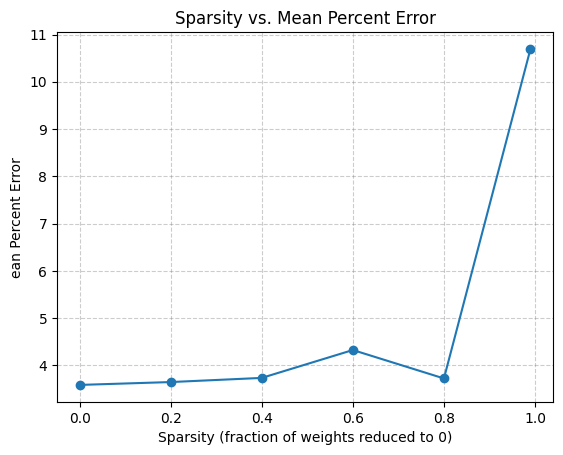

In [69]:
import matplotlib.pyplot as plt
def plot_sparsity_against_error(sparsity_values, model_means, model_stds):
    plt.errorbar(np.sort(sparsity_values), np.asarray(model_means)[np.argsort(sparsity_values)], fmt='o-')
    plt.xlabel("Sparsity (fraction of weights reduced to 0)")
    plt.ylabel("ean Percent Error")
    plt.grid(True, color='gray', linestyle='--', alpha=0.4)
    plt.title("Sparsity vs. Mean Percent Error")


plot_sparsity_against_error(sparsity_values, model_means, model_stds)

In [78]:
model = keras.models.load_model('models/500_pruned_8_32_8/0.99_sparsity')
model.save('models/500_pruned_8_32_8/0.99_sparsity.keras')